In [32]:
# !pip freeze > requirements.txt

In [1]:
!pip install -r requirements.txt 

  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached anyio-3.6.2-py3-none-any.whl (80 kB)
  Using cached arrow-1.2.3-py3-none-any.whl (66 kB)
  Using cached asttokens-2.2.1-py2.py3-none-any.whl (26 kB)
  Using cached attrs-22.2.0-py3-none-any.whl (60 kB)
  Using cached bcrypt-4.0.1-cp36-abi3-win_amd64.whl (152 kB)
  Using cached bleach-6.0.0-py3-none-any.whl (162 kB)
  Using cached blinker-1.6.2-py3-none-any.whl (13 kB)
  Using cached boxmot-10.0.52-py3-none-any.whl (1.6 MB)
  Using cached bs4-0.0.1.tar.gz (1.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached cfgv-3.4.0-py2.py3-none-any.whl (7.2 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached comm-0.1.3-py3-none-any.whl (6.6 kB)
  Using cached contourpy-1.0.7-cp310-cp310-win_amd64.whl (162 kB)
  Using ca

ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu117 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1)
ERROR: No matching distribution found for torch==2.0.1+cu117


In [2]:
!pip install ultralytics

In [3]:
!pip install torchvision

In [5]:
!pip install shapely

In [6]:
!pip install lapx

# TASK 1


For task1, I chose to combine color detection and shape detection to determine whether there is a complete pitch in the image, if the image can pass both tests, then the image will be saved to the corresponding folder in the exists folder, and its name will exist in the main directory single_frame.txt or double_frame.txt


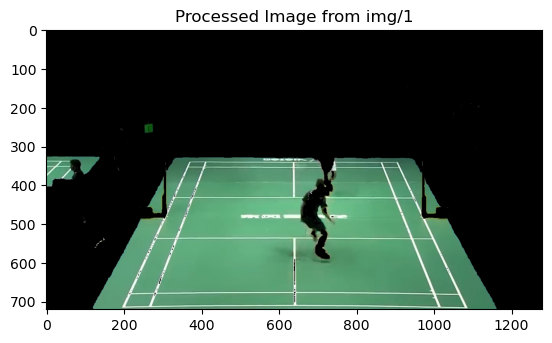

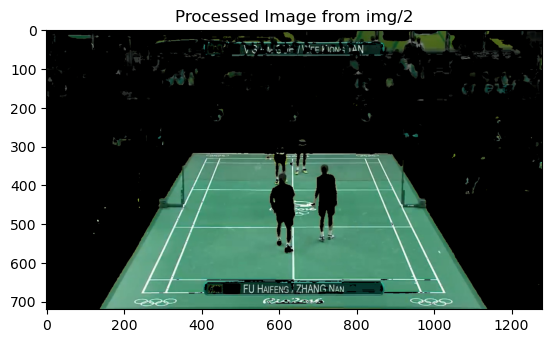

In [7]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

def process_random_image_from_directory(directory_path):
    # List all JPEG images in the directory
    all_images = [img for img in os.listdir(directory_path) if img.lower().endswith(('.jpeg', '.jpg'))]

    # Select a random image
    random_image_name = random.choice(all_images)
    random_image_path = os.path.join(directory_path, random_image_name)

    # Read and process the image
    img_org = cv2.imread(random_image_path)
    hsv = cv2.cvtColor(img_org, cv2.COLOR_BGR2HSV)

    lower_green = np.array([36, 0, 0])
    upper_green = np.array([86, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    res = cv2.bitwise_and(img_org, img_org, mask=mask)

    # Convert image from BGR to RGB for proper display in matplotlib
    res_rgb = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.imshow(res_rgb)
    plt.title(f'Processed Image from {directory_path}')
    plt.show()

# Set the directory paths
directory_path_single = 'img/1'
directory_path_double = 'img/2'

# Process a random image from each directory
process_random_image_from_directory(directory_path_single)
process_random_image_from_directory(directory_path_double)


In [8]:
import cv2
import numpy as np
import os
import re

def detect_quadrilateral_in_contours(edge_image):
    contours, _ = cv2.findContours(edge_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        if len(approximation) == 4:
            return True, approximation
    return False, None

def detect_court_color(imgHSV, threshold=0.1):
    h_min, h_max, s_min, s_max, v_min, v_max = 64, 100, 84, 145, 74, 255
    lower = np.array([h_min, s_min, v_min])
    upper = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(imgHSV, lower, upper)
    white_pixels = np.sum(mask == 255)
    total_pixels = mask.shape[0] * mask.shape[1]
    court_ratio = white_pixels / total_pixels
    court_exists = court_ratio > threshold
    return court_exists

def detect_tennis_court(image_path):
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_img, 50, 150, apertureSize=3)
    imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    court_color = detect_court_color(imgHSV)
    court_edge, quadrilateral = detect_quadrilateral_in_contours(edges)
    court_present = court_color and court_edge
    return court_present, edges, quadrilateral

def sort_key(filename):
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0
# Common function to process images
def process_image(filename, directory_path, exist_directory_path, output_file):
    if filename.lower().endswith((".jpeg", ".jpg")):
        image_path = os.path.join(directory_path, filename)
        img_org = cv2.imread(image_path)
        court_present, edges, quadrilateral = detect_tennis_court(image_path)

        if court_present:
            # If a tennis court is detected, write the image to the 'exist' folder
            save_path = os.path.join(exist_directory_path, filename)
            cv2.imwrite(save_path, img_org)
            # Write the name of the image with a tennis court to the corresponding file
            with open(output_file, 'a') as file:
                file.write(filename + '\n')
            print(f"{filename} - Court exists, saved to '{exist_directory_path}' folder and {output_file}")
        else:
            print(f"{filename} - No court found")
# Shared settings
path = '.'

# Settings for single frame
directory_path_single = 'img/1'
exist_directory_path_single = 'img/1/exist'
output_file_single = os.path.join(path, 'single_frame.txt')

# Settings for double frame
directory_path_double = 'img/2'
exist_directory_path_double = 'img/2/exist'
output_file_double = os.path.join(path, 'double_frame.txt')



print("Processing single frames...")
if not os.path.exists(exist_directory_path_single):
    os.makedirs(exist_directory_path_single)
if not os.path.exists(output_file_single):
    open(output_file_single, 'w').close()  # Create an empty file

for filename in sorted(os.listdir(directory_path_single), key=sort_key):
    process_image(filename, directory_path_single, exist_directory_path_single, output_file_single)

# Process for double frame
print("Processing double frames...")
if not os.path.exists(exist_directory_path_double):
    os.makedirs(exist_directory_path_double)
if not os.path.exists(output_file_double):
    open(output_file_double, 'w').close()  # Create an empty file

for filename in sorted(os.listdir(directory_path_double), key=sort_key):
    process_image(filename, directory_path_double, exist_directory_path_double, output_file_double)



Processing single frames...
frame1-SINGLE.jpeg - No court found
frame2-SINGLE.jpeg - No court found
frame3-SINGLE.jpeg - No court found
frame4-SINGLE.jpeg - No court found
frame5-SINGLE.jpeg - No court found
frame6-SINGLE.jpeg - No court found
frame7-SINGLE.jpeg - No court found
frame8-SINGLE.jpeg - No court found
frame9-SINGLE.jpeg - No court found
frame10-SINGLE.jpeg - No court found
frame11-SINGLE.jpeg - No court found
frame12-SINGLE.jpeg - No court found
frame13-SINGLE.jpeg - No court found
frame14-SINGLE.jpeg - No court found
frame15-SINGLE.jpeg - No court found
frame16-SINGLE.jpeg - No court found
frame17-SINGLE.jpeg - No court found
frame18-SINGLE.jpeg - No court found
frame19-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame20-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame21-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame22-SINGLE.jpeg - Court exists, saved to 'im

frame105-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame106-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame107-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame108-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame109-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame110-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame111-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame112-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame113-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame114-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame115-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame116-S

frame200-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame201-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame202-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame203-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame204-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame205-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame206-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame207-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame208-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame209-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame210-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame211-S

frame295-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame296-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame297-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame298-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame299-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame300-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame301-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame302-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame303-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame304-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame305-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame306-S

frame387-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame388-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame389-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame390-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame391-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame392-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame393-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame394-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame395-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame396-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame397-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame398-S

frame480-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame481-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame482-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame483-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame484-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame485-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame486-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame487-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame488-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame489-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame490-SINGLE.jpeg - Court exists, saved to 'img/1/exist' folder and .\single_frame.txt
frame491-S

KeyboardInterrupt: 

Output the ids of the two txt's containing the stadium's images

In [ ]:
single_frame_path = 'single_frame.txt'
double_frame_path = 'double_frame.txt'

try:
    with open(single_frame_path, 'r') as file:
        single_frame_content = file.read()
    print("single_frame.txt including：")
    print(single_frame_content)
except FileNotFoundError:
    print(f"file {single_frame_path} not found")

try:
    with open(double_frame_path, 'r') as file:
        double_frame_content = file.read()
    print("double_frame.txt including：")
    print(double_frame_content)
except FileNotFoundError:
    print(f"file {double_frame_path} not found")

# TASK2

In order to minimize the image interference, the region of the detected image should be as small as possible, for this I used deep learning yolov5 trained with single and double court datasets respectively, the training results are stored in yolov5/runs/train.For ease of viewing I copied them into the yolov5 folder and renamed them to single_model.pt and double_model.pt

In [9]:
!python yolov5/detect_court_single.py --source 1.jpeg --weights yolov5/single_model.pt


python: can't open file 'C:\\Users\\HP\\Desktop\\lyu-code\\jupyter\\yolov5\\detect_court_single.py': [Errno 2] No such file or directory


In [15]:
!python yolov5/detect_court_double.py --source 2.jpeg --weights yolov5/double_model.pt

detect_court_double: weights=['yolov5/double_model.pt'], source=2.jpeg, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=0, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-290-gb2ffe055 Python-3.10.9 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 C:\Users\HP\Desktop\notebook\2.jpeg: 384x640 1 court, 99.7ms
Speed: 1.0ms pre-process, 99.7ms inference, 0.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5\runs\detect\exp3


## The output is stored in yolov5\run\detect\exp xxx

Take the detection of double_court as an example, using the training best.pt to detect the court image, although it is not possible to obtain the four vertex coordinates of the court, but it is possible to obtain a more accurate range for the subsequent cropping of the image to reduce a lot of interference elements

Look for the box_label function in detect.py. Since this is a modification of the plotting.py function from my own computer environment, the above run of detect_court will not output the coordinates. Only the code to modify box_label is provided here. If it is necessary, you need to manually modify the box_label in the py file, and then run detect.py again to get the coordinates of the four vertices recognized.

In [41]:
    def box_label(self, box, label="", color=(128, 128, 128), txt_color=(255, 255, 255), rotated=False):
        """Add one xyxy box to image with label."""
        if isinstance(box, torch.Tensor):
            box = box.tolist()
        if self.pil or not is_ascii(label):
            if rotated:
                p1 = box[0]
                # NOTE: PIL-version polygon needs tuple type.
                self.draw.polygon([tuple(b) for b in box], width=self.lw, outline=color)
            else:
                p1 = (box[0], box[1])
                self.draw.rectangle(box, width=self.lw, outline=color)  # box
            if label:
                w, h = self.font.getsize(label)  # text width, height
                outside = p1[1] - h >= 0  # label fits outside box
                self.draw.rectangle(
                    (p1[0], p1[1] - h if outside else p1[1], p1[0] + w + 1, p1[1] + 1 if outside else p1[1] + h + 1),
                    fill=color,
                )
                # self.draw.text((box[0], box[1]), label, fill=txt_color, font=self.font, anchor='ls')  # for PIL>8.0
                self.draw.text((p1[0], p1[1] - h if outside else p1[1]), label, fill=txt_color, font=self.font)
        else:  # cv2
            if rotated:
                p1 = [int(b) for b in box[0]]
                # NOTE: cv2-version polylines needs np.asarray type.
                cv2.polylines(self.im, [np.asarray(box, dtype=int)], True, color, self.lw)
            else:
                p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
                cv2.rectangle(self.im, p1, p2, color, thickness=self.lw, lineType=cv2.LINE_AA)
                cv2.circle(self.im, ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2), self.lw, (0, 0, 255), self.lw)
                # Print coordinate information
                print("The coordinates of the upper left point are：(" + str(p1[0]) + "," + str(p1[1]) + ")，The coordinates of the upper right point are(" + str(p2[0]) + "," + str(
                    p1[1]) + ")")
                print("The coordinates of the lower left point are：(" + str(p1[0]) + "," + str(p2[1]) + ")，The coordinates of the lower right point are(" + str(p2[0]) + "," + str(
                    p2[1]) + ")")

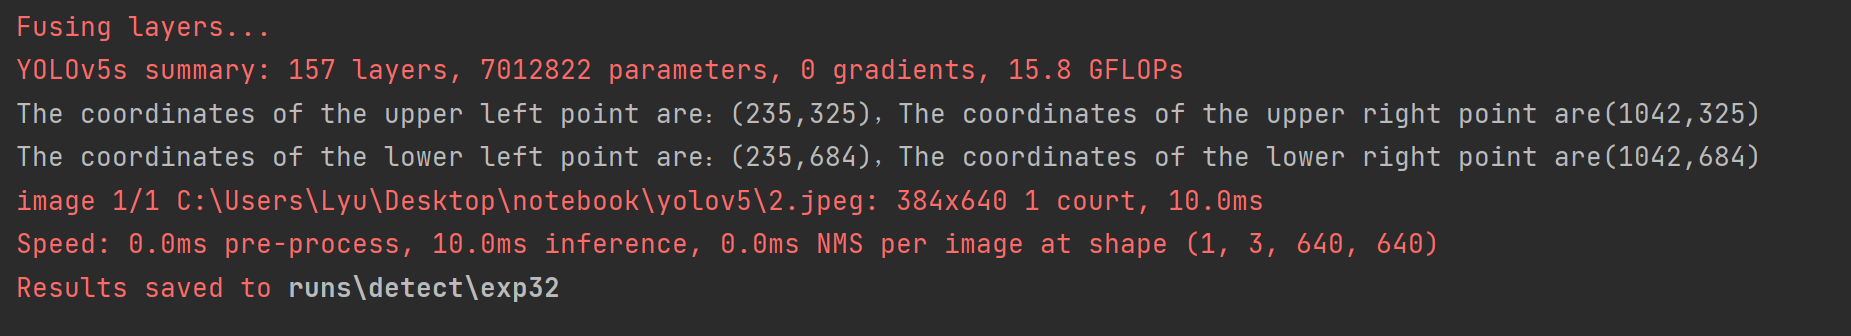

## Note that the coordinates of these four points are carried into the subsequent function for further processing.

In [4]:

# YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
# The coordinates of the upper left point are：(235,325)，The coordinates of the upper right point are(1042,325)
# The coordinates of the lower left point are：(235,684)，The coordinates of the lower right point are(1042,684)
# image 1/1 C:\Users\Lyu\Desktop\notebook\yolov5\2.jpeg: 384x640 1 court, 13.9ms
# Speed: 0.0ms pre-process, 13.9ms inference, 4.0ms NMS per image at shape (1, 3, 640, 640)
# Results saved to runs\detect\exp25

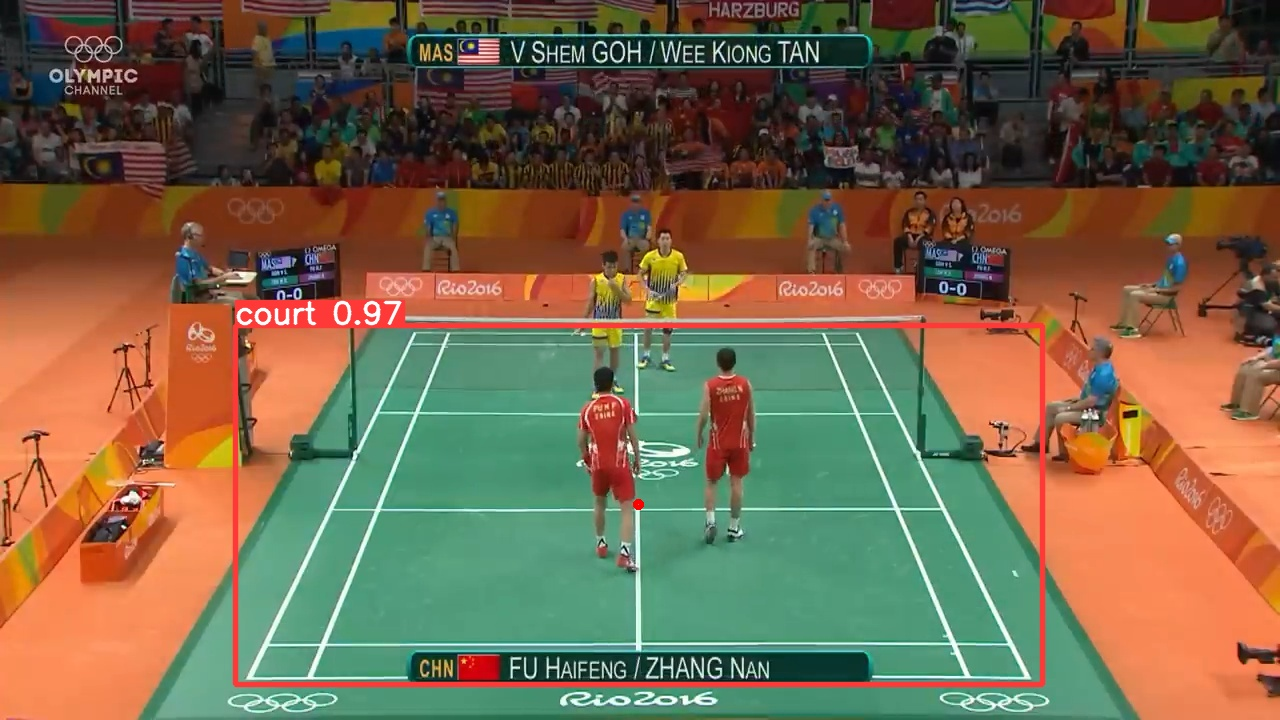

## Note that the coordinates of these four points are carried into the subsequent function for further processing

Output of runs/train/exp3/weights/best.pt.
Result of single_court

In [58]:
# YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
# The coordinates of the upper left point are：(183,337)，The coordinates of the upper right point are(1099,337)
# The coordinates of the lower left point are：(183,719)，The coordinates of the lower right point are(1099,719)
# image 1/1 C:\Users\Lyu\Desktop\notebook\yolov5\1.jpeg: 384x640 1 court, 17.2ms
# Speed: 0.0ms pre-process, 17.2ms inference, 5.0ms NMS per image at shape (1, 3, 640, 640)

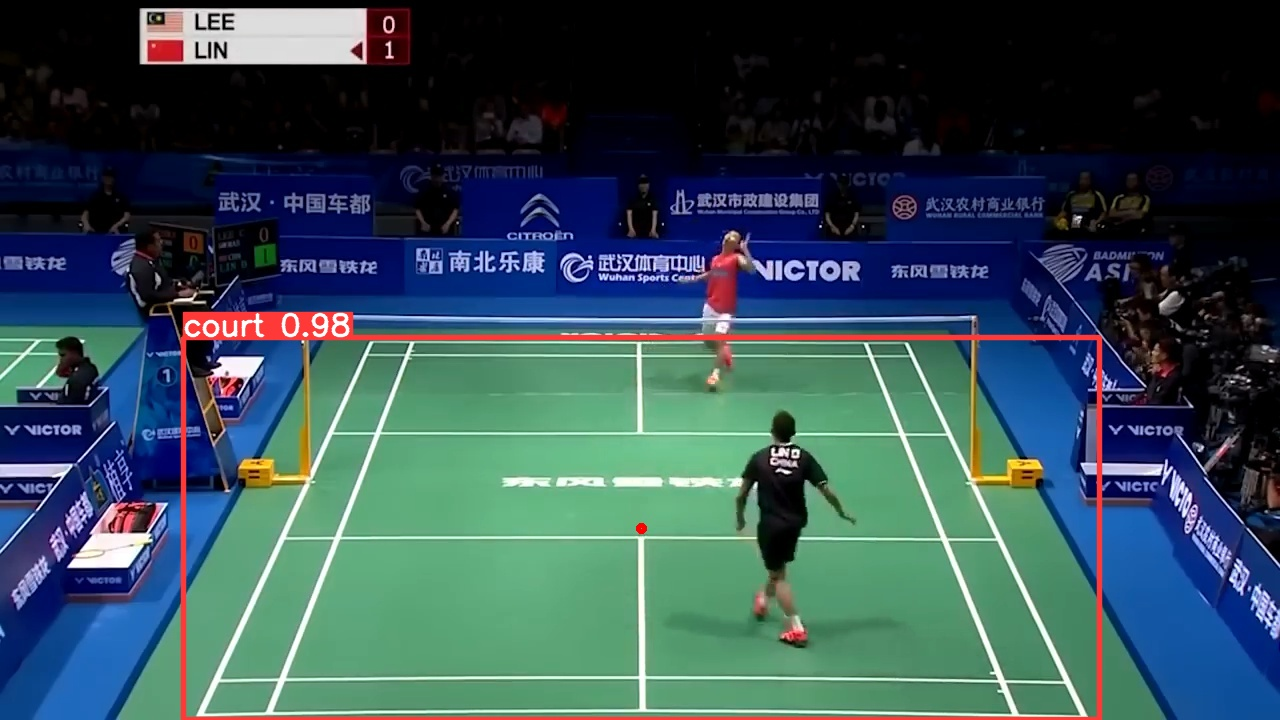

For the court extracted in Task 2, I will give a detailed description of the process using a single court as an example, while the dual-court section will only provide the complete code, output results, and part of the description.

## Single_court detection

First is the binarization process, I carried out various tests on the initial processing of the image, including binarization processing as well as the conversion of HSV adjustment parameters, the final test result is that the binarized image is more convenient for subsequent line extraction

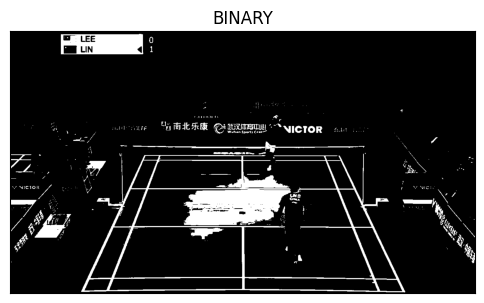

In [46]:
from matplotlib import pyplot as plt
import cv2 as cv
# Reading images and converting them to grayscale
img_org = cv.imread('1.jpeg')  # single_court_picture
img = cv.cvtColor(img_org, cv.COLOR_BGR2GRAY)
# THRESH_BINARY
ret, th1 = cv.threshold(img, 150, 255, cv.THRESH_BINARY)
images = [th1]
titles = ['BINARY']
plt.figure(figsize=(6, 6))
plt.imshow(images[0], 'gray') 
plt.title(titles[0])
plt.xticks([]), plt.yticks([]) 
plt.show()

The approximate pitch location extracted by calling the deep learning result model eliminates many useless results
Apply Canny Edge Detection and Hough Line Transform to the specified region to get the straight line bars in the region, at this point the preliminary detection has been completed

Considering that a single pitch image with text in the middle will be misrecognized as a straight line, so I adjusted the parameter maxLineGap in the function HoughLinesP to 14, but then there will be a lot of lines that can not be recognized, so I used a one-time recognition of multiple images and then append the unified recognition results to a variable and then proceed to the next step of the analysis

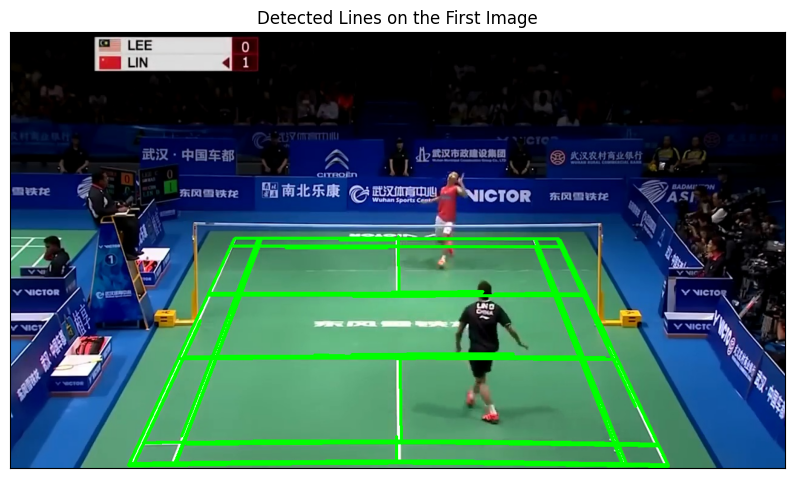

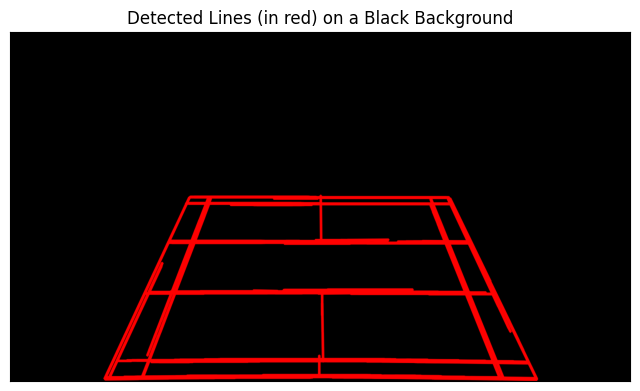

In [47]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os

directory = 'img_for_singlecourt/'  # Replace 'your_directory_path/' with your actual directory path

all_files = os.listdir(directory)

image_paths = [os.path.join(directory, f) for f in all_files if f.endswith('.jpeg') or f.endswith('.jpg')]
all_lines = []

p1 = (183, 337)
p2 = (1099, 337)
p3 = (183, 719)
p4 = (1099, 719)



for path in image_paths:
    img_org = cv.imread(path)
    img = cv.cvtColor(img_org, cv.COLOR_BGR2GRAY)
    ret, th1 = cv.threshold(img, 150, 255, cv.THRESH_BINARY)
    roi = th1[p1[1]:p4[1], p1[0]:p4[0]]
    v = np.median(roi)
    sigma = 0.33
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges_roi = cv.Canny(roi, 50, 150, apertureSize=3)

    linesP = cv.HoughLinesP(edges_roi, rho=1, theta=np.pi/180, threshold=120, minLineLength=10, maxLineGap=14)
#         linesP = cv.HoughLinesP(edges_roi, 1, np.pi / 180, 120, None, 52, 60)
    if linesP is not None:
        for line in linesP:
            all_lines.append(line)

img_org = cv.imread('1.jpeg')
for line in all_lines:
    x1, y1, x2, y2 = line[0]
    cv.line(img_org, (x1+p1[0], y1+p1[1]), (x2+p1[0], y2+p1[1]), (0, 255, 0), 3)

plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(img_org, cv.COLOR_BGR2RGB))
plt.title('Detected Lines on the First Image'), plt.xticks([]), plt.yticks([])
plt.show()




modified_lines = []

if all_lines is not None:
    modified_lines = np.zeros_like(all_lines)  # Create an array with the same shape as linesP
    for i in range(len(all_lines)):
        l = all_lines[i][0]
        #  Adjustment of coordinates
        modified_line = [l[0] + p1[0], l[1] + p1[1], l[2] + p1[0], l[3] + p1[1]]
        modified_lines[i][0] = modified_line

black_background = np.zeros_like(img_org)

for line in modified_lines:
    l = line[0]  # Get a list of actual line coordinates
    x1, y1, x2, y2 = l # And then unpack these four coordinates
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3, cv.LINE_AA)

plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(black_background, cv.COLOR_BGR2RGB))
plt.title('Detected Lines (in red) on a Black Background'), plt.xticks([]), plt.yticks([])
plt.show()

Set two queues to separate the obtained lines into horizontal and vertical line groups for processing

In [48]:
def segment_lines(lines, deltaX, deltaY):
    h_lines = []
    v_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if abs(y2-y1) < deltaY: # y-values are near; line is horizontal
                h_lines.append(line)
            elif abs(x2-x1) < deltaX: # x-values are near; line is vertical
                v_lines.append(line)
    return h_lines, v_lines
h_lines, v_lines = segment_lines(modified_lines, 450, 10) 
print('Number of horizontal lines: ', len(h_lines)) 
print('Number of vertical lines: ', len(v_lines))
print('Total number of lines: ', modified_lines.shape[0]) 

Number of horizontal lines:  173
Number of vertical lines:  54
Total number of lines:  227


To reduce the number of useless lines, measure the distance between the different lines in the vertical line set, and if the two lines are close together, use the highest and lowest points of both as the two endpoints of the new line

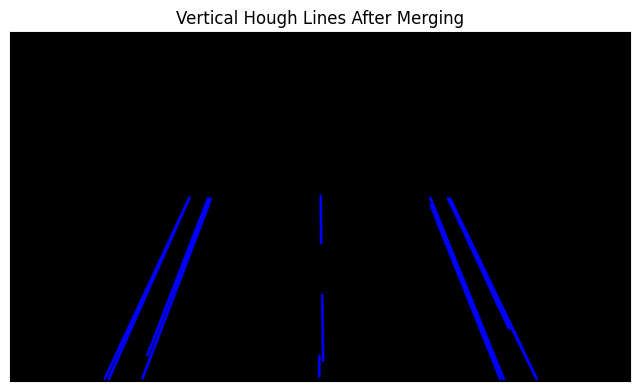

In [49]:
black_background1 = np.zeros_like(img_org)
def line_distance(line1, line2):
    x11, y11, x12, y12 = line1[0]
    x21, y21, x22, y22 = line2[0]
# Calculate the distance from each endpoint to the endpoint of the other line and find the minimum value    
    distances = [
        np.sqrt((x11 - x21)**2 + (y11 - y21)**2),
        np.sqrt((x11 - x22)**2 + (y11 - y22)**2),
        np.sqrt((x12 - x21)**2 + (y12 - y21)**2),
        np.sqrt((x12 - x22)**2 + (y12 - y22)**2)
    ]
    
    return min(distances)
def merge_lines(lines, threshold=20):  #  default 20
    merged_lines = []
    used_index = set()
    
    for i, line1 in enumerate(lines):
        if i in used_index:
            continue

        min_dist = np.inf
        merge_with = -1
        for j, line2 in enumerate(lines):
            if j != i and j not in used_index:
                dist = line_distance(line1, line2)
                if dist < threshold: 
                    min_dist = dist
                    merge_with = j
                    break  # Stop at the first close line found for simplicity

        if merge_with != -1:
            # Merge line1 with line2 (merge_with)
            line2 = lines[merge_with]
            used_index.add(i)
            used_index.add(merge_with)
            all_points = [line1[0][:2], line1[0][2:], line2[0][:2], line2[0][2:]]
            # Sort points from highest (smallest y) to lowest (largest y)
            all_points.sort(key=lambda x: (x[1], x[0]))
            # Take the topmost and bottommost points as the new merged line
            new_line = [all_points[0], all_points[-1]]
            merged_lines.append(np.array([new_line], dtype=np.int32))
        else:
            # No close line found, keep the original
            if i not in used_index:
                merged_lines.append(line1)

    return merged_lines

def correct_format(merged_lines):
    corrected_lines = []
    for line in merged_lines:
        # Flatten the line array to make sure it is a single list of points.
        flat_line = line.ravel()  # This will convert array of shape [1, 4] or [2, 2] to a flat array
        # Then create a new formatted line with shape [1, 4]
        new_line = np.array([[flat_line[0], flat_line[1], flat_line[2], flat_line[3]]], dtype=np.int32)
        corrected_lines.append(new_line)
    return corrected_lines
# Re-run with corrected merge_lines function
vx_lines = merge_lines(v_lines,threshold=34)
vx_lines_corrected = correct_format(vx_lines)
# print(vx_lines_corrected)
black_background2 = np.zeros_like(img_org)
# Draw the merged line segments
for i in range(len(vx_lines_corrected)):
    l = vx_lines_corrected[i][0] 
    cv.line(black_background2, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv.LINE_AA)
plt.figure(figsize=(8, 6))
plt.imshow(black_background2, cmap='magma')
plt.title('Vertical Hough Lines After Merging'), plt.xticks([]), plt.yticks([])
plt.show()


Horizontal line groups are treated in a similar way as above. In order to reduce the number of useless lines, the distance between the different lines in the horizontal line group is measured, and if the two lines are close together, the leftmost and rightmost points of both are used as the two endpoints of the new line

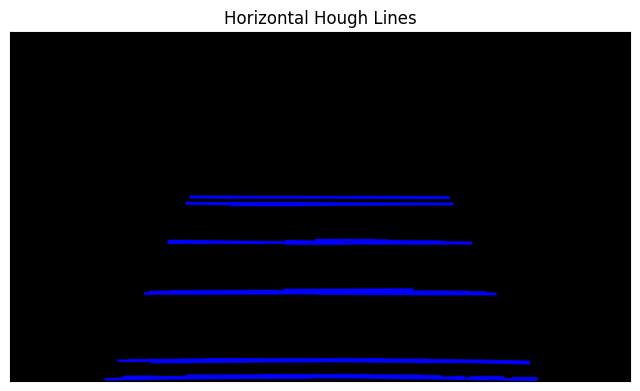

In [50]:
def merge_horizontal_lines(lines, threshold=20):  # The default threshold is set to 20
    merged_lines = []
    used_index = set()
    
    for i, line1 in enumerate(lines):
        if i in used_index:
            continue

        min_dist = np.inf
        merge_with = -1
        for j, line2 in enumerate(lines):
            if j != i and j not in used_index:
                dist = line_distance(line1, line2)
                if dist < threshold:
                    min_dist = dist
                    merge_with = j
                    break  # Stop at the first close line found for simplicity

        if merge_with != -1:
            line2 = lines[merge_with]
            used_index.add(i)
            used_index.add(merge_with)
            all_points = [line1[0][:2], line1[0][2:], line2[0][:2], line2[0][2:]]
            # Sort points from leftmost (smallest x) to rightmost (largest x)
            all_points.sort(key=lambda x: (x[0], x[1]))
            # Take the leftmost and rightmost points as the new merged line
            new_line = [all_points[0], all_points[-1]]
            merged_lines.append(np.array([new_line], dtype=np.int32))
        else:
            # No close line found, keep the original
            if i not in used_index:
                merged_lines.append(line1)

    return merged_lines
black_background3 = np.zeros_like(img_org)
hx_lines = merge_horizontal_lines(h_lines,threshold=12)

hx_lines_corrected = correct_format(hx_lines)
# Drawing Vertical Hough Lines on image 
for i in range(len(hx_lines_corrected)): 
    l = hx_lines_corrected[i][0] 
    cv.line(black_background3, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
plt.figure(figsize=(8,6)) 
plt.imshow(black_background3, cmap='magma') 
plt.title('Horizontal Hough Lines'), plt.xticks([]), plt.yticks([])
plt.show() 


The group of two lines that have been processed and merged is detected, and all intersections of the horizontal and vertical line groups are detected

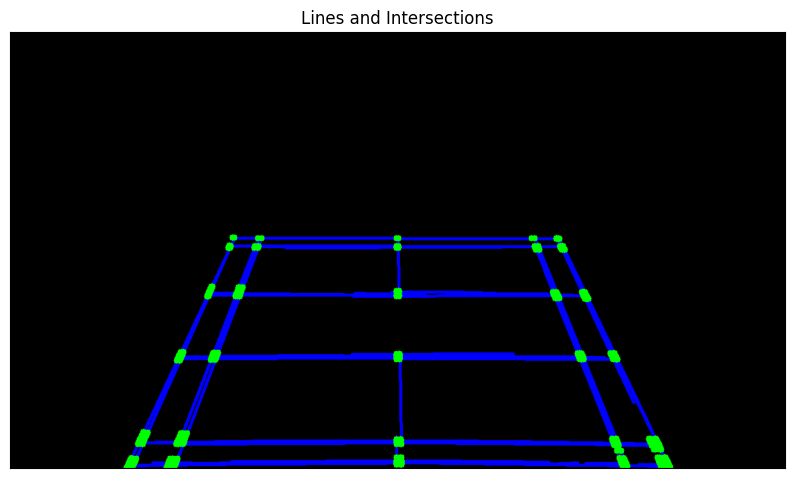

In [51]:
black_background = np.zeros_like(img_org) 
def line_intersection(line1, line2):
    if len(line1.shape) > 1:
        x1, y1, x2, y2 = line1.flatten()  
    else:
        x1, y1, x2, y2 = line1 

    if len(line2.shape) > 1:
        x3, y3, x4, y4 = line2.flatten()
    else:
        x3, y3, x4, y4 = line2
    # Calculate the intersection
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if den == 0:
        return None  # lines are parallel
    else:
        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / den
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / den
        return (int(px), int(py))
    
intersections = []  

# Calculate the point of intersection for each pair of vertical and horizontal lines
for v_line in vx_lines:
    for h_line in hx_lines:
        point = line_intersection(v_line[0], h_line[0])  # Properly process NumPy arrays to match function requirements
        if point:  # If a point of intersection is indeed found
            if 0 <= point[0] < img_org.shape[1] and 0 <= point[1] < img_org.shape[0]:  # Check to see if it's within the image
                intersections.append(point)
for v_line in vx_lines:
    # Ensure coordinates are correctly extracted from line segments
    if len(v_line[0]) == 4:  
        x1, y1, x2, y2 = v_line[0]
    else:  
        x1, y1, x2, y2 = v_line.flatten() 
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)

# Drawing horizontal lines

for h_line in hx_lines:
#     print(h_line)
#     print("ddd")
    if len(h_line[0]) == 4: 
        x1, y1, x2, y2 = h_line[0]
    else: 
        x1, y1, x2, y2 = h_line.flatten() 
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
for point in intersections:
    cv.circle(black_background, point, radius=5, color=(0, 255, 0), thickness=-1)
plt.figure(figsize=(10, 8))
plt.imshow(black_background)
plt.title('Lines and Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

Points merge, because the line processing can not be called perfect, so there are still a lot of redundant intersections, in order to reduce the interference, further points merge, if the distance between two points is less than the value of que, then the average of the coordinates of the two points as the new point.

In [52]:
def merge_close_points(points, threshold=10.5):
    points = np.array(points)
    merged = True  # Used to track whether a merger has taken place

    while merged:
        merged = False  # Assuming no merger occurs in this round
        new_points = []  # Used to store merged point sets

        while points.shape[0] > 0:
            # Take a point and compare it to other points
            point = points[0]
            rest = points[1:]

             # Calculate the distance of this point from other points in the set
            distances = np.linalg.norm(rest - point, axis=1)

            #  Check for points that are too close together           
            close_points = rest[distances < threshold]

            if close_points.shape[0] > 0:
                # If there are close points, merge with those points #           
                combined_point = np.mean(np.vstack((point, close_points)), axis=0)
                new_points.append(combined_point)  
                points = rest[distances >= threshold] 
                merged = True  
            else:
                new_points.append(point)
                points = rest 

         # Update the point set to the new merged point set    
        points = np.array(new_points)

    return points.tolist()
black_background = np.zeros_like(img_org)

merged_intersections = merge_close_points(intersections)
# print(merged_intersections)


# Plot the merged intersection           
for point in merged_intersections:
    point = tuple(map(int, point))
    cv.circle(black_background, point, radius=5, color=(0, 255, 0), thickness=-1)
# plt.figure(figsize=(10, 8))
# plt.imshow(black_background)
# plt.title('Merged Intersections'), plt.xticks([]), plt.yticks([])
# plt.show()

Due to the nature of the image, it can be known that the two most right and left points in the image must be the two vertices of the boundary of the court, traverse to get these two vertices, and then these two vertices and any two vertices in the group of vertices to be combined to form a quadrilateral, and then compare the area of all the quadrangles, and the four points of the quadrilateral with the largest area are the four vertices of the court.
If you do not consider the leftmost and rightmost points, you can also directly choose any four points for comparison, but this will take a lot of time.

This part gets the coordinates of the four vertices for almost all of the subsequent functions

the four point of the whole court: [[1078.8078842315367, 712.0598178642714], [192.0, 719.0], [369.0, 339.0], [904.5, 340.6]]


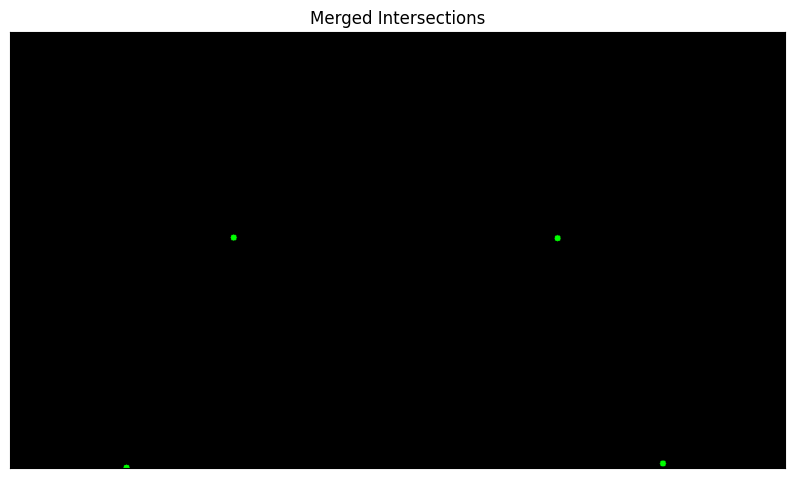

In [53]:

from scipy.spatial import ConvexHull
import numpy as np

from itertools import combinations
from shapely.geometry import Polygon, Point

def is_simple_polygon(points):
    polygon = Polygon(points)
    return polygon.is_simple

def polygon_area(points):
    polygon = Polygon(points)
    return polygon.area
min_x_point = min(merged_intersections, key=lambda x: x[0])
max_x_point = max(merged_intersections, key=lambda x: x[0])
remaining_points = [p for p in merged_intersections if p != min_x_point and p != max_x_point]
max_area = 0
best_polygon = None
for comb in combinations(remaining_points, 2):
    quad = [max_x_point,min_x_point] + list(comb)  
    polygon = Polygon(quad)
    if polygon.is_valid:
        area = polygon.area
        if area > max_area:
            max_area = area
            best_polygon = quad

# # Have all possible combination
# combs = combinations(merged_intersections, 4)
# # Filter out combinations 
# simple_polygons = [list(comb) for comb in combs if is_simple_polygon(comb)]
# max_area = 0
# best_polygon = None
# for polygon in simple_polygons:
#     area = polygon_area(polygon)
#     if area > max_area:
#         max_area = area
#         best_polygon = polygon
print("the four point of the whole court:",best_polygon)

black_background1 = np.zeros_like(img_org)
for point in best_polygon:
    point = tuple(map(int, point))
    cv.circle(black_background1, point, radius=5, color=(0, 255, 0), thickness=-1)
for h_line in hx_lines:
    if len(h_line[0]) == 4: 
        x1, y1, x2, y2 = h_line[0]
    else: 
        x1, y1, x2, y2 = h_line.flatten()  
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.figure(figsize=(10, 8))
plt.imshow(black_background1)
plt.title('Merged Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

Combine all previously obtained line segments and intersections into the same drawing for subsequent output of the 2D top view. Considering that the last four vertex coordinates obtained in the previous step are [[1078.8078842315367, 712.0598178642714], [192.0, 719.0], [369.0, 339.0], [904.5, 340.6]], optimize the decimal point to facilitate the computation to read [[1079, 712], [ 192.0, 719.0], [369.0, 339.0], [904.5, 340.6]]

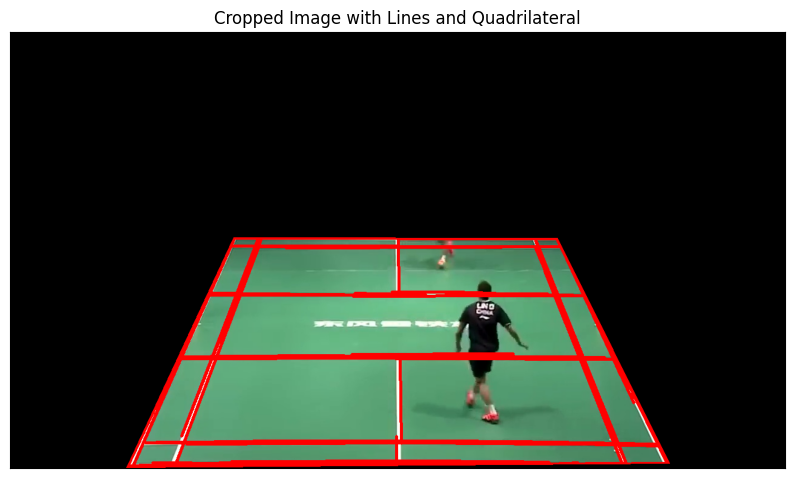

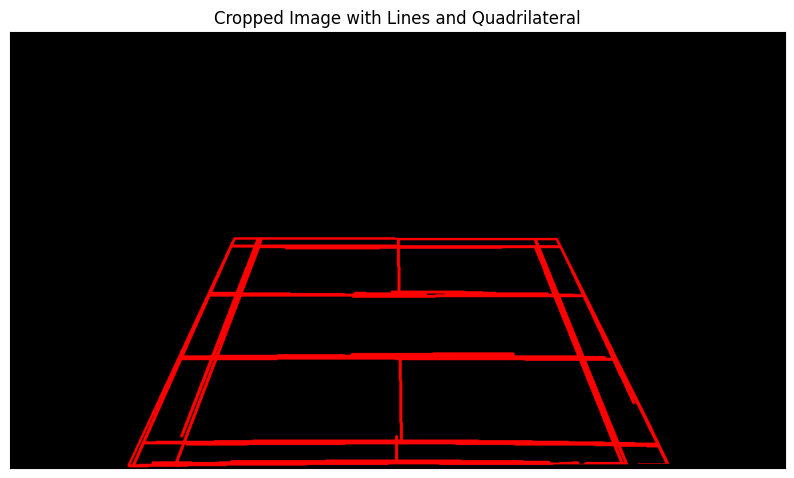

In [54]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

black_background = np.zeros_like(img_org)
mask = np.zeros_like(img_org)
img_org = cv.imread('1.jpeg')  # single_court_picture

# Coordinates of the four points output from the previous part of the code
quad_vertices = [(369.0, 339.0), (192.0, 719.0), (1089, 712), (904.5, 340.6)]
quad_vertices_int = np.array(quad_vertices, dtype=np.int32).reshape((-1, 1, 2))

# Draw quadrilateral frames and fill masks
cv2.polylines(img_org, [quad_vertices_int], isClosed=True, color=(0, 0, 255), thickness=3)
cv2.fillPoly(mask, [quad_vertices_int], color=(255, 255, 255))

for v_line in vx_lines:
    
    if len(v_line[0]) == 4:  
        x1, y1, x2, y2 = v_line[0]
    else:  
        x1, y1, x2, y2 = v_line.flatten()
    cv.line(img_org, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
for h_line in hx_lines:
    if len(h_line[0]) == 4: 
        x1, y1, x2, y2 = h_line[0]
    else: 
        x1, y1, x2, y2 = h_line.flatten()
    cv.line(img_org, (x1, y1), (x2, y2), (0, 0, 255), 3)
# for point in merged_intersections:
#     cv2.circle(img_org, tuple(map(int, point)), radius=5, color=(0, 255, 0), thickness=-1)
result = cv2.bitwise_and(img_org, mask)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Lines and Quadrilateral'), plt.xticks([]), plt.yticks([])
plt.show()




# Draw quadrilateral frames and fill masks
cv2.polylines(img_org, [quad_vertices_int], isClosed=True, color=(0, 0, 255), thickness=3)
cv2.fillPoly(mask, [quad_vertices_int], color=(255, 255, 255))

for v_line in vx_lines:
    
    if len(v_line[0]) == 4:  
        x1, y1, x2, y2 = v_line[0]
    else:  
        x1, y1, x2, y2 = v_line.flatten()
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
for h_line in hx_lines:
    if len(h_line[0]) == 4: 
        x1, y1, x2, y2 = h_line[0]
    else: 
        x1, y1, x2, y2 = h_line.flatten()
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
# for point in merged_intersections:
#     cv2.circle(black_background, tuple(map(int, point)), radius=5, color=(0, 255, 0), thickness=-1)
result = cv2.bitwise_and(black_background, mask)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Lines and Quadrilateral'), plt.xticks([]), plt.yticks([])
plt.show()

Crop out the part of the court based on the four vertices and then stretch the image according to the proportions of the court provided in the pdf. Note that here stretching the picture must be used in opencv perspective transformation, simple stretching will make the picture in the proportion of the site to produce changes

### Considering that the single pitch is not the same as the double, we need to crop a part of the pitch if required to get the area we want. Now we have detected a large court that matches the two-person motion, but we now need a small area for the single-person court.

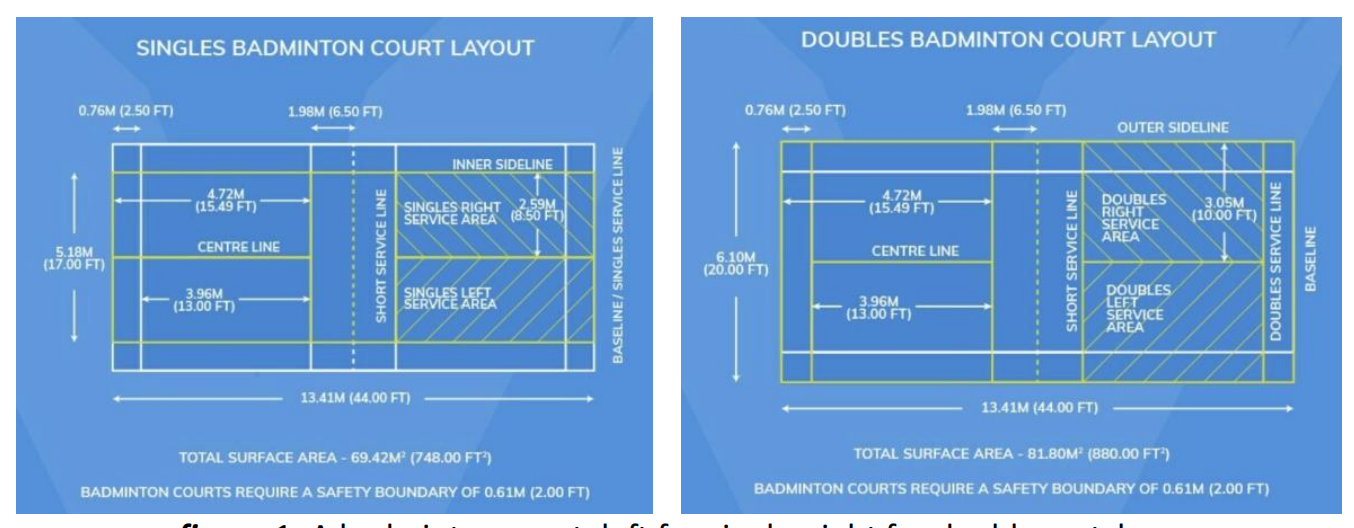

Based on the scale in the pdf we find the coordinates of the four vertices of the single area of the pitch in the 2d model diagram as [[ 0. 0.] [ 0. 1341.] [ 610. 1341.] [ 610. 0.]]. Then the coordinates corresponding to these four vertices in the original figure are obtained by perspective transformation

The coordinates of the single part court corresponding to the original map.: [[ 409.96     339.12238]
 [ 261.2719   718.4594 ]
 [1022.9514   712.51544]
 [ 864.6886   340.48105]]


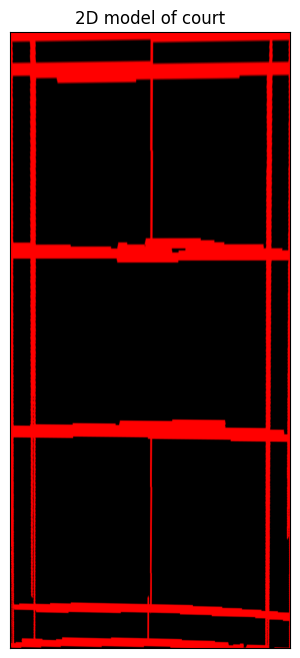

In [55]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
quad_vertices = np.array( [(369, 339), (192, 719), (1089, 712), (904.5, 340.6)], dtype="float32")
# [(369.0, 339.0), (192.0, 719.0), (1089, 712), (904.5, 340.6)]
# the length 13.41m corresponds to the two sides of the trapezoid, and the width 5.18m corresponds to the top and bottom of the trapezoid.
# Suppose we draw the court at a certain scale, e.g. 100 pixels per unit of length.
width, height = 610, 1341
dst_vertices = np.array([
    [0, 0],
    [0, height],
    [width, height],
    [width, 0]
], dtype="float32")

# Calculate the perspective transformation matrix
M = cv2.getPerspectiveTransform(quad_vertices, dst_vertices)

# Apply perspective transformations
warped = cv2.warpPerspective(black_background, M, (width, height))
# Define the points in the current (transformed) image and the original image
pts_transformed_A = np.array([[46, 0], [46, 1341], [564, 1341], [564, 0]], dtype=np.float32)
pts_transformed_B = np.array([[0, 0], [0, 1341], [610, 1341], [610, 0]], dtype=np.float32)
pts_original_B = np.array([[369.0, 339.0], [192.0, 719.0], [1089, 712], [904.5, 340.6]], dtype=np.float32)
# Compute the perspective transform matrix from B to original
matrix_B_to_original = cv2.getPerspectiveTransform(pts_transformed_B, pts_original_B)
# Use the computed matrix to transform A points to the original image coordinates
pts_original_A = cv2.perspectiveTransform(np.array([pts_transformed_A]), matrix_B_to_original)[0]
line_data = []
# Connect each point to the next to form four lines #
for i in range(len(pts_original_A)):
    start_point = pts_original_A[i]
    end_point = pts_original_A[(i + 1) % len(pts_original_A)]
    line_data.append([[int(start_point[0]), int(start_point[1])], [int(end_point[0]), int(end_point[1])]])
print("The coordinates of the single part court corresponding to the original map.:",pts_original_A)
# print(line_data)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('2D model of court'), plt.xticks([]), plt.yticks([])
plt.show()

According to the coordinates obtained above, we then apply mask and process the image to draw the newly obtained boundary lines and vertices, with the new boundary drawn in yellow color

The coordinates of the single court.: [[ 409.96     339.12238]
 [ 261.2719   718.4594 ]
 [1022.9514   712.51544]
 [ 864.6886   340.48105]]


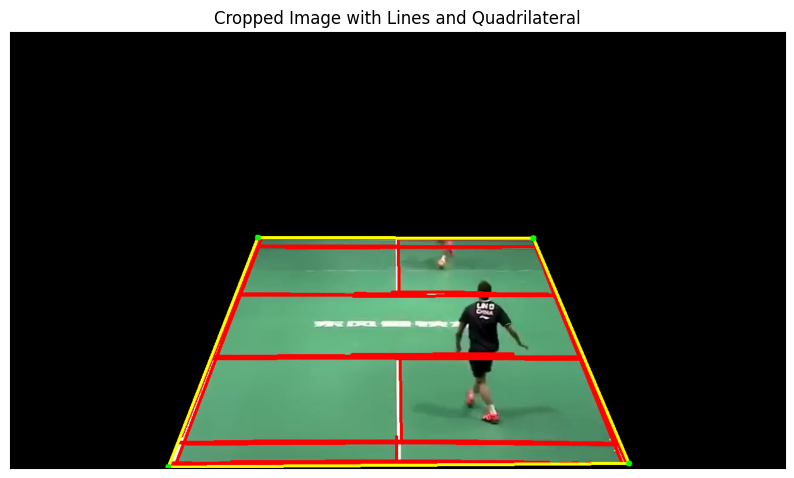

The coordinates of the single part court corresponding to the original map.: [[ 409.96     339.12238]
 [ 261.2719   718.4594 ]
 [1022.9514   712.51544]
 [ 864.6886   340.48105]]


In [56]:
mask = np.zeros_like(img_org)
img_org = cv2.imread('1.jpeg')
# Coordinates of the four points output from the previous part of the code
quad_vertices = [
    (409.96  , 339.12238), 
    (261.2719  ,718.4594), 
    (1022.9514 , 712.51544), 
    (864.6886  , 340.48105)
]

quad_vertices_int = np.array(quad_vertices, dtype=np.int32).reshape((-1, 1, 2))
# Draw quadrilateral frames and fill masks
cv2.polylines(img_org, [quad_vertices_int], isClosed=True, color=(0, 0, 255), thickness=3)
cv2.fillPoly(mask, [quad_vertices_int], color=(255, 255, 255))

for v_line in vx_lines:
    
    if len(v_line[0]) == 4:  
        x1, y1, x2, y2 = v_line[0]
    else:  
        x1, y1, x2, y2 = v_line.flatten()
    cv.line(img_org, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
for h_line in hx_lines:
    if len(h_line[0]) == 4: 
        x1, y1, x2, y2 = h_line[0]
    else: 
        x1, y1, x2, y2 = h_line.flatten()
    cv.line(img_org, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
    
    
# for point in merged_intersections:
#     cv2.circle(img_org, tuple(map(int, point)), radius=5, color=(0,255,0), thickness=-1)
result = cv2.bitwise_and(img_org, mask)    
   
    
for v_line in line_data:
    x1, y1 = v_line[0]
    x2, y2 = v_line[1]
    cv2.line(result, (x1, y1), (x2, y2), (0, 255, 255), 3)
for point in quad_vertices:
    cv2.circle(result, tuple(map(int, point)), radius=5, color=(0, 255, 0), thickness=-1)     
print("The coordinates of the single court.:",pts_original_A)
    
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Lines and Quadrilateral'), plt.xticks([]), plt.yticks([])
plt.show()    
print("The coordinates of the single part court corresponding to the original map.:",pts_original_A)




## Double_court_detection

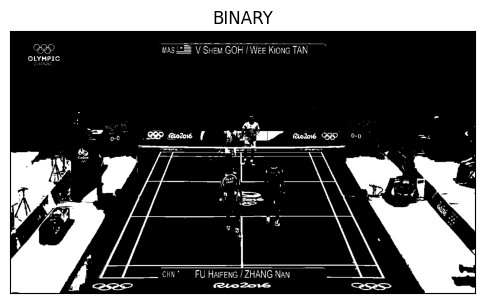

In [57]:
from matplotlib import pyplot as plt
import cv2 as cv
# Reading images and converting them to grayscale
img_org = cv.imread('2.jpeg')  # double_court_picture
img = cv.cvtColor(img_org, cv.COLOR_BGR2GRAY)
# THRESH_BINARY
ret, th1 = cv.threshold(img, 150, 255, cv.THRESH_BINARY)
images = [th1]
titles = ['BINARY']
plt.figure(figsize=(6, 6))
plt.imshow(images[0], 'gray') 
plt.title(titles[0])
plt.xticks([]), plt.yticks([]) 
plt.show()

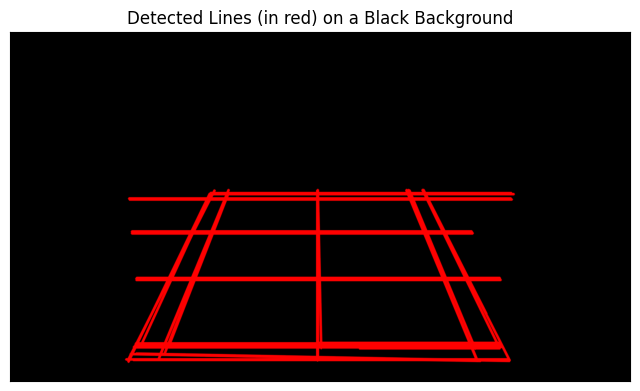

In [58]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
# Read the image and convert it to a grayscale image.
img_org = cv.imread('2.jpeg')  # Ensure the path is correct.
img = cv.cvtColor(img_org, cv.COLOR_BGR2GRAY)
# Apply binary thresholding.
ret, th1 = cv.threshold(img, 150, 255, cv.THRESH_BINARY)
# Define corner points for the Region Of Interest (ROI).
p1, p2, p3, p4 = (235,325), (1042,325), (235,684), (1042,684)
roi = th1[p1[1]:p4[1], p1[0]:p4[0]]
v = np.median(roi)
sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges_roi = cv.Canny(roi, lower, upper, apertureSize=3)

linesP = cv.HoughLinesP(edges_roi, 1, np.pi / 160, 82, None, 180, 250)

black_background = np.zeros_like(img_org)

modified_lines = []

if linesP is not None:
    modified_lines = np.zeros_like(linesP)  
    for i in range(len(linesP)):
        l = linesP[i][0]
        modified_line = [l[0] + p1[0], l[1] + p1[1], l[2] + p1[0], l[3] + p1[1]]
        modified_lines[i][0] = modified_line 
black_background = np.zeros_like(img_org)

for line in modified_lines:
    l = line[0]  
    x1, y1, x2, y2 = l  
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3, cv.LINE_AA)
plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(black_background, cv.COLOR_BGR2RGB))
plt.title('Detected Lines (in red) on a Black Background'), plt.xticks([]), plt.yticks([])
plt.show()


In [59]:
def segment_lines(lines, deltaX, deltaY):
    #seperate the lines into two groups
    h_lines = []
    v_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if abs(y2-y1) < deltaY:
                h_lines.append(line)
            elif abs(x2-x1) < deltaX:
                v_lines.append(line)
    return h_lines, v_lines
h_lines, v_lines = segment_lines(modified_lines, 450, 10) 


Number of horizontal lines:  20
Number of vertical lines:  17
Total number of lines:  39


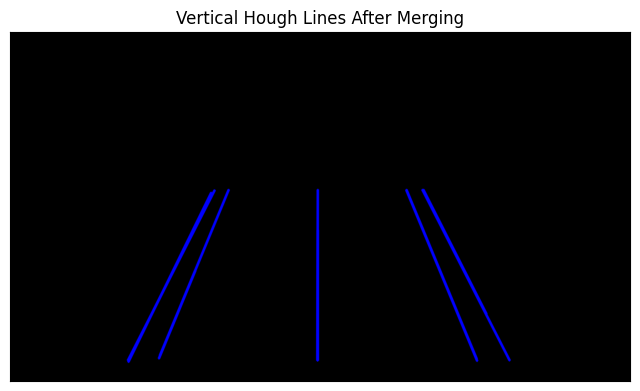

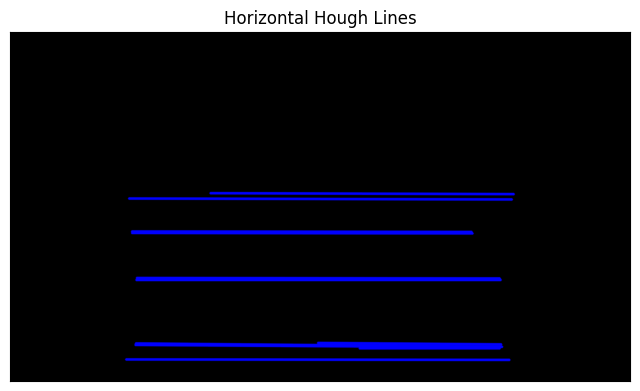

In [60]:
def line_distance(line1, line2):
    x11, y11, x12, y12 = line1[0]
    x21, y21, x22, y22 = line2[0]
    
    distances = [
        np.sqrt((x11 - x21)**2 + (y11 - y21)**2),
        np.sqrt((x11 - x22)**2 + (y11 - y22)**2),
        np.sqrt((x12 - x21)**2 + (y12 - y21)**2),
        np.sqrt((x12 - x22)**2 + (y12 - y22)**2)
    ]
    
    return min(distances)
def merge_lines(lines, threshold=20):
    merged_lines = []
    used_index = set()
    for i, line1 in enumerate(lines):
        if i in used_index:
            continue
        min_dist = np.inf
        merge_with = -1
        for j, line2 in enumerate(lines):
            if j != i and j not in used_index:
                dist = line_distance(line1, line2)
                if dist < threshold: 
                    min_dist = dist
                    merge_with = j
                    break  # Stop at the first close line found for simplicity
        if merge_with != -1:
            line2 = lines[merge_with]
            used_index.add(i)
            used_index.add(merge_with)
            all_points = [line1[0][:2], line1[0][2:], line2[0][:2], line2[0][2:]]
            all_points.sort(key=lambda x: (x[1], x[0]))
            new_line = [all_points[0], all_points[-1]]
            merged_lines.append(np.array([new_line], dtype=np.int32))
        else:
            if i not in used_index:
                merged_lines.append(line1)
    return merged_lines

def correct_format(merged_lines):
    corrected_lines = []
    for line in merged_lines:
        flat_line = line.ravel() 
        new_line = np.array([[flat_line[0], flat_line[1], flat_line[2], flat_line[3]]], dtype=np.int32)
        corrected_lines.append(new_line)
    return corrected_lines
vx_lines = merge_lines(v_lines,threshold=31)
vx_lines_corrected = correct_format(vx_lines)
# print(vx_lines_corrected)
black_background2 = np.zeros_like(img_org)
for i in range(len(vx_lines_corrected)):
    l = vx_lines_corrected[i][0]  
    cv.line(black_background2, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv.LINE_AA)
plt.figure(figsize=(8, 6))
plt.imshow(black_background2, cmap='magma')
plt.title('Vertical Hough Lines After Merging'), plt.xticks([]), plt.yticks([])
plt.show()




black_background3 = np.zeros_like(img_org)
hx_lines = merge_lines(h_lines,threshold=13)

hx_lines_corrected = correct_format(hx_lines)
# Drawing Vertical Hough Lines on image 
for i in range(len(hx_lines_corrected)): 
    l = hx_lines_corrected[i][0] 
    cv.line(black_background3, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
    
plt.figure(figsize=(8,6)) 
plt.imshow(black_background3, cmap='magma') 
plt.title('Horizontal Hough Lines'), plt.xticks([]), plt.yticks([])
plt.show() 
    


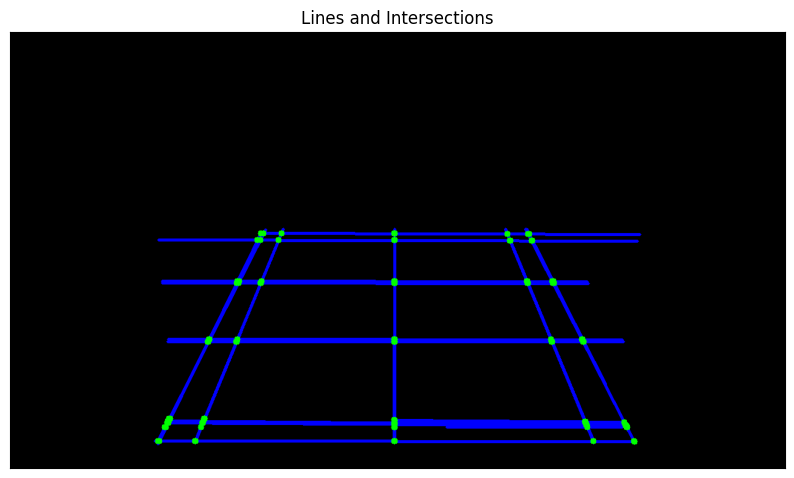

In [66]:
black_background = np.zeros_like(img_org) 
def line_intersection(line1, line2):
    if len(line1.shape) > 1:
        x1, y1, x2, y2 = line1.flatten()  
    else:
        x1, y1, x2, y2 = line1 
    if len(line2.shape) > 1:
        x3, y3, x4, y4 = line2.flatten()
    else:
        x3, y3, x4, y4 = line2
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if den == 0:
        return None  # lines are parallel
    else:
        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / den
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / den
        return (int(px), int(py))
intersections = [] 
for v_line in vx_lines:
    for h_line in hx_lines:
        point = line_intersection(v_line[0], h_line[0]) 
        if point:  
            if 0 <= point[0] < img_org.shape[1] and 0 <= point[1] < img_org.shape[0]: 
                intersections.append(point)
for v_line in vx_lines:
    if len(v_line[0]) == 4:  
        x1, y1, x2, y2 = v_line[0]
    else: 
        x1, y1, x2, y2 = v_line.flatten()  
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
for h_line in hx_lines:
    if len(h_line[0]) == 4: 
        x1, y1, x2, y2 = h_line[0]
    else:  
        x1, y1, x2, y2 = h_line.flatten()  
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
for point in intersections:
    cv.circle(black_background, point, radius=5, color=(0, 255, 0), thickness=-1)
plt.figure(figsize=(10, 8))
plt.imshow(black_background)
plt.title('Lines and Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

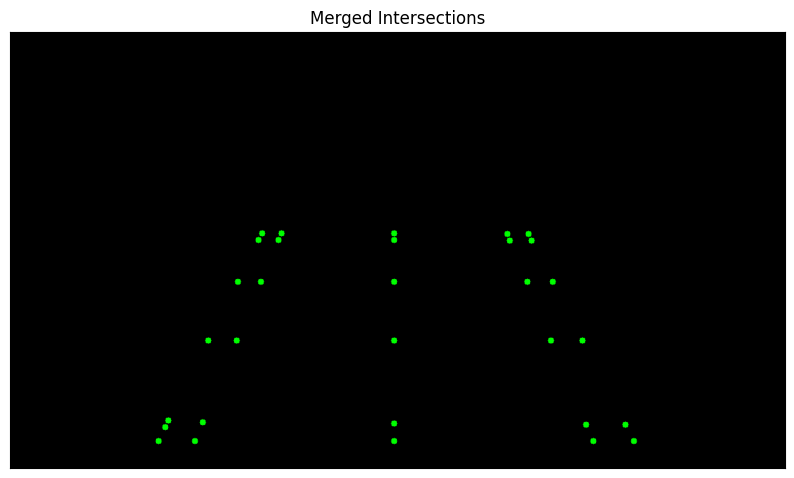

In [67]:
def merge_close_points(points, threshold=11):
    points = np.array(points)
    merged = True  
    while merged:
        merged = False  
        new_points = []  
        while points.shape[0] > 0:
            point = points[0]
            rest = points[1:]
            distances = np.linalg.norm(rest - point, axis=1)
            close_points = rest[distances < threshold]
            if close_points.shape[0] > 0:
                combined_point = np.mean(np.vstack((point, close_points)), axis=0)
                new_points.append(combined_point)  
                points = rest[distances >= threshold]  
                merged = True  
            else:
                new_points.append(point)
                points = rest  
        points = np.array(new_points)
    return points.tolist()  
black_background = np.zeros_like(img_org)  

merged_intersections = merge_close_points(intersections)
# print(merged_intersections)
for point in merged_intersections:
    point = tuple(map(int, point))
    cv.circle(black_background, point, radius=5, color=(0, 255, 0), thickness=-1)
# print(merged_intersections)
plt.figure(figsize=(10, 8))
plt.imshow(black_background)
plt.title('Merged Intersections'), plt.xticks([]), plt.yticks([])
plt.show()
#As you can see, many of the intersections are fused, which greatly facilitates our subsequent operations.

[[410.5, 343.0], [261.3333333333333, 641.6666666666666], [416.0, 332.0], [327.5, 509.0], [376.0, 412.5], [256.0, 652.0], [825.5, 344.0], [951.5, 648.0], [821.0, 333.0], [893.75, 509.0], [854.0, 412.5], [963.0, 675.0], [443.0, 343.0], [318.0, 644.25], [448.0, 332.0], [374.25, 509.0], [414.25, 412.5], [305.5, 675.0], [861.5, 344.0], [1016.625, 648.75], [856.0, 333.0], [945.5, 509.0], [896.5, 412.5], [634.5, 343.0], [634.5, 646.125], [634.5, 332.0], [634.5, 509.0], [634.5, 412.5], [634.5, 675.0]]
[[1030.5, 675.5], [245.0, 675.0], [416.0, 332.0], [856.0, 333.0]]


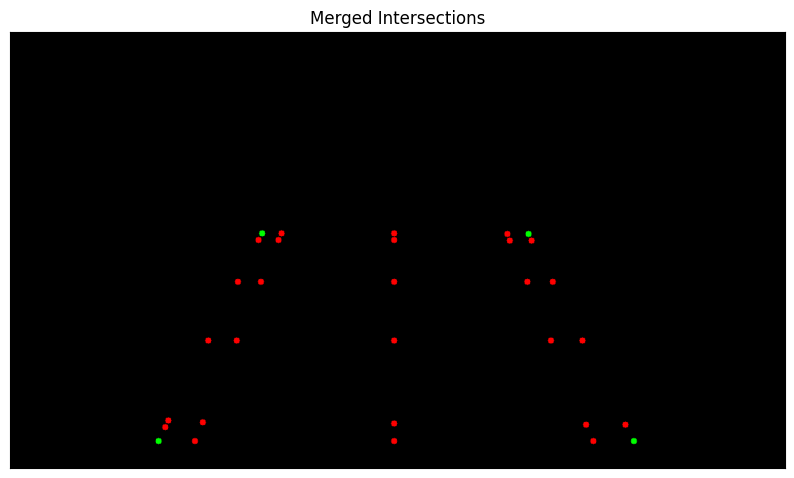

In [68]:
from scipy.spatial import ConvexHull
import numpy as np
from itertools import combinations
from shapely.geometry import Polygon, Point
def is_simple_polygon(points):
    polygon = Polygon(points)
    return polygon.is_simple
def polygon_area(points):
    polygon = Polygon(points)
    return polygon.area
min_x_point = min(merged_intersections, key=lambda x: x[0])
max_x_point = max(merged_intersections, key=lambda x: x[0])
# Remove the leftmost and rightmost points that have been selected
remaining_points = [p for p in merged_intersections if p != min_x_point and p != max_x_point]
max_area = 0
best_quad = None
# print(remaining_points)

for comb in combinations(remaining_points, 2):
    quad = [max_x_point,min_x_point] + list(comb)
    polygon = Polygon(quad)
#     print(polygon)
    if polygon.is_valid:
        area = polygon.area
        if area > max_area:
            max_area = area
            best_quad = quad
#With these data, we have coordinates of the four vertices of the pitch
print(best_quad)
black_background1 = np.zeros_like(img_org)
for point in merged_intersections:
    point = tuple(map(int, point))
    cv.circle(black_background1, point, radius=5, color=(255, 0, 0), thickness=-1)    
for point in best_quad:
    point = tuple(map(int, point))
    cv.circle(black_background1, point, radius=5, color=(0, 255, 0), thickness=-1)
plt.figure(figsize=(10, 8))
plt.imshow(black_background1)
plt.title('Merged Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

[[1030.5, 675.5], [245.0, 675.0], [416.0, 332.0], [856.0, 333.0]]


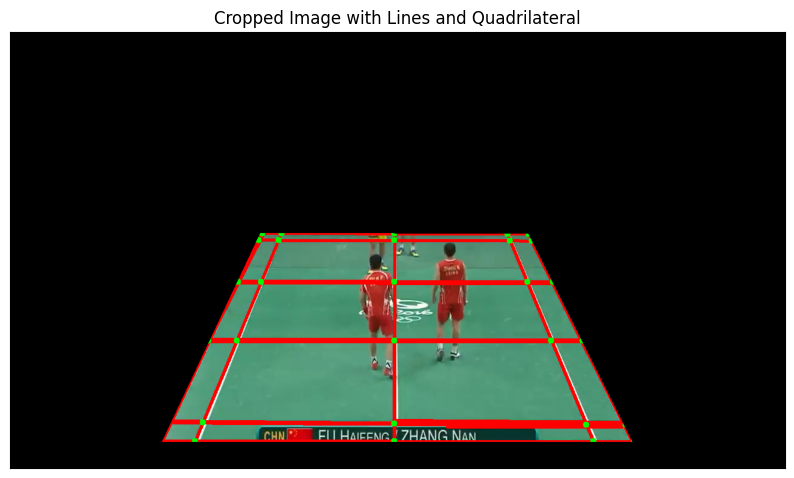

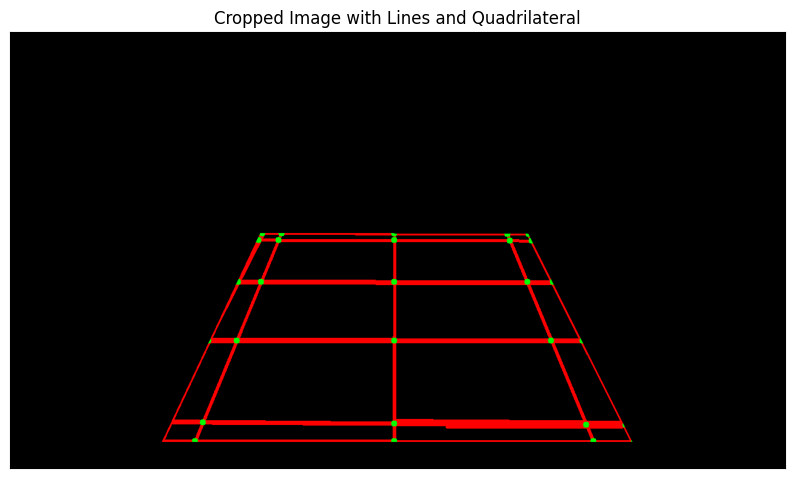

In [69]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img_org = cv.imread('2.jpeg')  # single_court_picture
black_background = np.zeros_like(img_org)
mask = np.zeros_like(img_org) 
quad_vertices = [(1027.5, 676.6666666666667), (251.0, 676.5), (413.5, 332.0), (855.6666666666666, 333.0)]
#the data was obtained in previous steps
quad_vertices_int = np.array(quad_vertices, dtype=np.int32).reshape((-1, 1, 2))
print(best_quad)
cv2.polylines(black_background, [quad_vertices_int], isClosed=True, color=(0, 0, 255), thickness=3)
cv2.fillPoly(mask, [quad_vertices_int], color=(255, 255, 255)) 

# Draw quadrilateral frames and fill masks
cv2.polylines(img_org, [quad_vertices_int], isClosed=True, color=(0, 0, 255), thickness=3)
cv2.fillPoly(mask, [quad_vertices_int], color=(255, 255, 255))
for v_line in vx_lines:
    if len(v_line[0]) == 4:  
        x1, y1, x2, y2 = v_line[0]
    else:  
        x1, y1, x2, y2 = v_line.flatten()
    cv.line(img_org, (x1, y1), (x2, y2), (0, 0, 255), 3)
for h_line in hx_lines:
    if len(h_line[0]) == 4: 
        x1, y1, x2, y2 = h_line[0]
    else: 
        x1, y1, x2, y2 = h_line.flatten()
    cv.line(img_org, (x1, y1), (x2, y2), (0, 0, 255), 3)
for point in merged_intersections:
    cv2.circle(img_org, tuple(map(int, point)), radius=5, color=(0, 255, 0), thickness=-1)
result = cv2.bitwise_and(img_org, mask)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Lines and Quadrilateral'), plt.xticks([]), plt.yticks([])
plt.show()


for v_line in vx_lines:
    if len(v_line[0]) == 4: 
        x1, y1, x2, y2 = v_line[0]
    else:
        x1, y1, x2, y2 = v_line.flatten()  
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
for h_line in hx_lines:
    if len(h_line[0]) == 4:  
        x1, y1, x2, y2 = h_line[0]
    else:  
        x1, y1, x2, y2 = h_line.flatten()  
    cv.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3)
for point in merged_intersections:  
    cv2.circle(black_background, tuple(map(int, point)), radius=5, color=(0, 255, 0), thickness=-1)
result = cv2.bitwise_and(black_background, mask)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image with Lines and Quadrilateral'), plt.xticks([]), plt.yticks([])
plt.show()

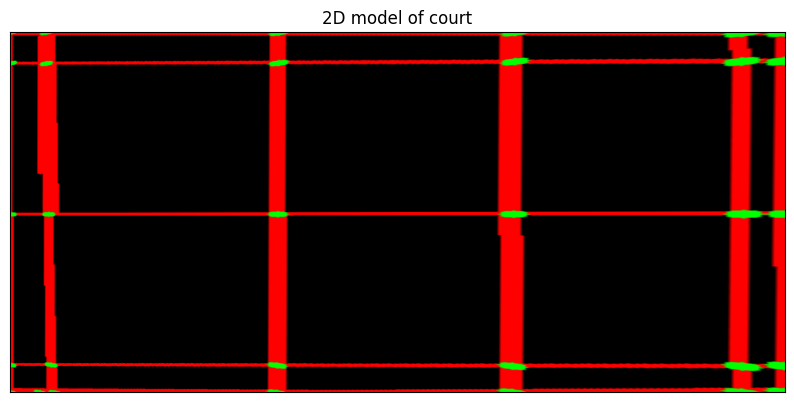

In [70]:
#Extract 2D model of double court

import cv2
import numpy as np
from matplotlib import pyplot as plt

# [[1030.5, 675.5], [245.0, 675.0], [416.0, 332.0], [856.0, 333.0]]
quad_vertices = np.array([(1030.5, 675.5), (245.0, 675.0), (416.0, 332.0), (856.0, 333.0)], dtype="float32")
height = 610
width = 1314
dst_vertices = np.array([
    [0, 0],
    [0, height],
    [width, height],
    [width, 0]
], dtype="float32")
M = cv2.getPerspectiveTransform(quad_vertices, dst_vertices)
warped = cv2.warpPerspective(black_background, M, (width, height))
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('2D model of court'), plt.xticks([]), plt.yticks([])
plt.show()


# TASK3

Target Recognition, in order to accomplish this task I chose to call Yolov5 as a tool to implement it, the main goal of this task I think is to exclude the influence of spectators and other people and to focus only on detecting the athletes, for this I tried to implement the function in two different ways.


## Method 1, using yolov5

The first method, considering that by task2 we can get the coordinates of the four corners of the stadium, I created a mask for these four coordinates, masking out all the areas I don't want to detect, and only detecting the area within the area, the effect is shown below.As you can see, the player located at the other end of the pitch is not detected well, as his upper body will be outside the boundary line and not detected because of perspective, so I have improved the second method for this situation


Below are some early test results

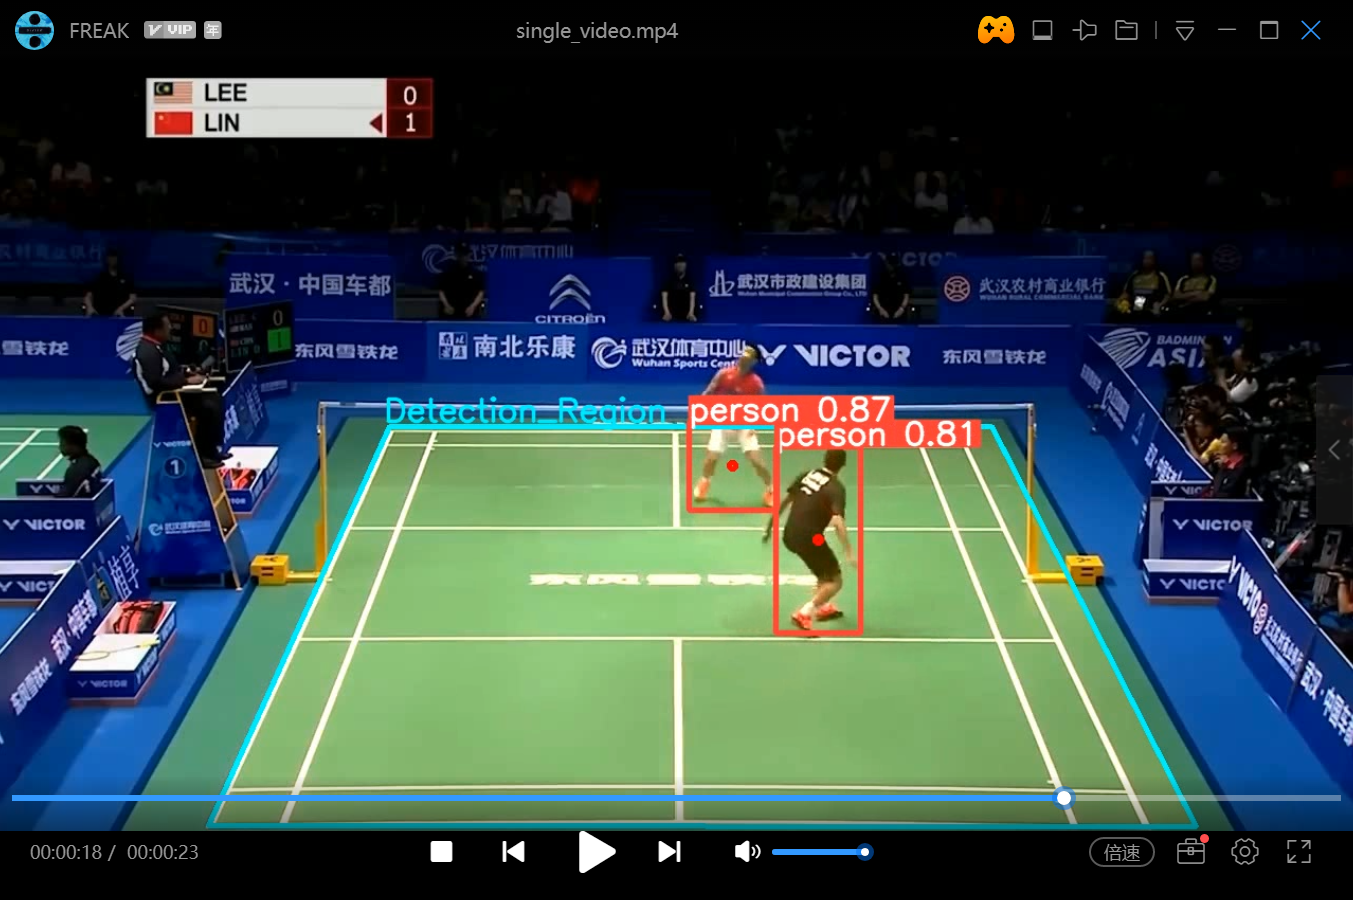


For the second approach, I defined an example quadrilateral region and its corresponding Polygon object. For each target that is detected in its entirety, the program makes a judgment about the midpoint at the bottom of its recognition box, and if the player's bottom midpoint is out of bounds, it is judged to be out of bounds, which avoids the trouble that occurs in method one

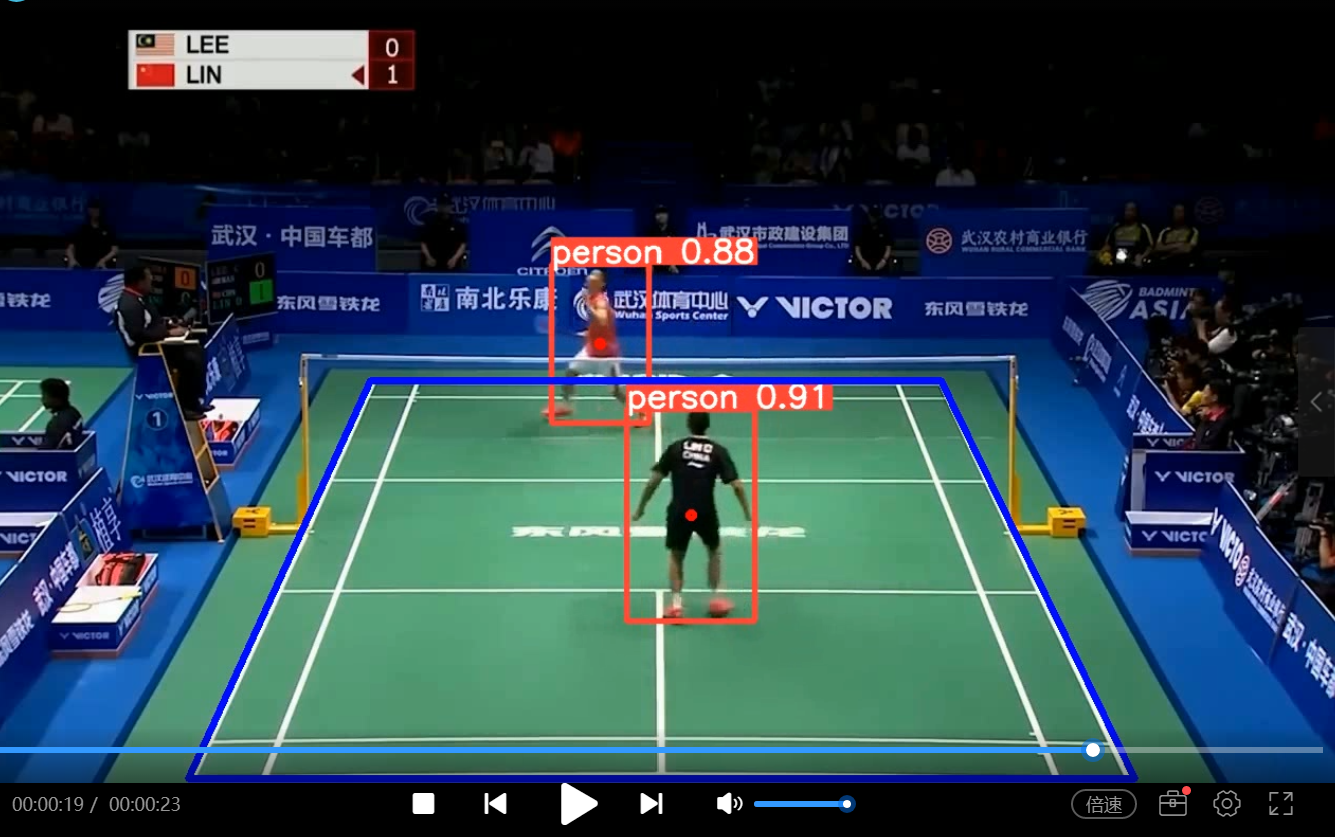

The results are stored in the exp directory of notebook\yolov5\runs\detect.

In [71]:
import sys
sys.path
from yolov5 import detect_player_single
detect_player_single.run(weights='yolov5s.pt', source='single_video.avi', classes = [0])

YOLOv5  v7.0-290-gb2ffe055 Python-3.10.11 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
video 1/1 (1/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 6 persons, 30.0ms
video 1/1 (2/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 6 persons, 11.0ms
video 1/1 (3/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 6 persons, 11.0ms
video 1/1 (4/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 7 persons, 10.0ms
video 1/1 (5/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 6 persons, 11.0ms
video 1/1 (6/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 6 persons, 10.5ms
video 1/1 (7/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 7 persons, 10.0ms
video 1/1 (8/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 8 persons, 11.0ms
video 1/1 (9/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x6

video 1/1 (87/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (88/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (89/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (90/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (91/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (92/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (93/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (94/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (95/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (96/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (97/478) C:\Users\Lyu\Desktop\notebook\single_video.a

video 1/1 (174/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 4.0ms
video 1/1 (175/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 4.0ms
video 1/1 (176/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 4.0ms
video 1/1 (177/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 13.0ms
video 1/1 (178/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 12 persons, 10.0ms
video 1/1 (179/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 12.0ms
video 1/1 (180/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (181/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 10.0ms
video 1/1 (182/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (183/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (184/478) C:\Users\Lyu\Desktop\notebook\single

video 1/1 (261/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 10.0ms
video 1/1 (262/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (263/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (264/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 7.0ms
video 1/1 (265/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 10.0ms
video 1/1 (266/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 10.0ms
video 1/1 (267/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 10.0ms
video 1/1 (268/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 18.0ms
video 1/1 (269/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (270/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (271/478) C:\Users\Lyu\Desktop\notebook\singl

video 1/1 (348/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 13 persons, 7.0ms
video 1/1 (349/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 13 persons, 7.0ms
video 1/1 (350/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 14 persons, 7.0ms
video 1/1 (351/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 13 persons, 7.0ms
video 1/1 (352/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 12 persons, 7.0ms
video 1/1 (353/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 14 persons, 7.0ms
video 1/1 (354/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 13 persons, 7.0ms
video 1/1 (355/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 13 persons, 8.0ms
video 1/1 (356/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 13 persons, 14.0ms
video 1/1 (357/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 14 persons, 8.0ms
video 1/1 (358/478) C:\Users\Lyu\Desktop\notebook\single_vi

video 1/1 (435/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (436/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 8.0ms
video 1/1 (437/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (438/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 8.0ms
video 1/1 (439/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 8.0ms
video 1/1 (440/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (441/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 8.0ms
video 1/1 (442/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (443/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (444/478) C:\Users\Lyu\Desktop\notebook\single_video.avi: 384x640 11 persons, 9.0ms
video 1/1 (445/478) C:\Users\Lyu\Desktop\notebook\single_vid

In [72]:
import sys
sys.path
from yolov5 import detect_player_double
detect_player_double.run(weights='yolov5s.pt', source='double_video.avi', classes = [0])

YOLOv5  v7.0-290-gb2ffe055 Python-3.10.11 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
video 1/1 (1/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 8 persons, 38.0ms
video 1/1 (2/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 11 persons, 27.1ms
video 1/1 (3/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 26.0ms
video 1/1 (4/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 24.9ms
video 1/1 (5/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 24.0ms
video 1/1 (6/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 8 persons, 26.0ms
video 1/1 (7/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 9 persons, 20.1ms
video 1/1 (8/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 9 persons, 18.9ms
video 1/1 (9/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 3

video 1/1 (88/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 17.0ms
video 1/1 (89/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 9 persons, 9.0ms
video 1/1 (90/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 9 persons, 9.0ms
video 1/1 (91/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (92/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 7.0ms
video 1/1 (93/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (94/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 9 persons, 10.0ms
video 1/1 (95/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 10.0ms
video 1/1 (96/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 11 persons, 6.0ms
video 1/1 (97/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 11 persons, 6.9ms
video 1/1 (98/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384

video 1/1 (176/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 11 persons, 10.0ms
video 1/1 (177/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 11 persons, 8.0ms
video 1/1 (178/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (179/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 7.1ms
video 1/1 (180/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 10.0ms
video 1/1 (181/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 9.9ms
video 1/1 (182/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (183/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 9.0ms
video 1/1 (184/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 7.0ms
video 1/1 (185/225) C:\Users\Lyu\Desktop\notebook\double_video.avi: 384x640 10 persons, 8.0ms
video 1/1 (186/225) C:\Users\Lyu\Desktop\notebook\double_v

In [9]:
#Help me output video results in jupyter
from IPython.display import clear_output,  display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import time
import cv2
import os
def show_video(video_path:str,small:int=2):
    if not os.path.exists(video_path):
        print("the video / the file are not exist")
    video = cv2.VideoCapture(video_path)
    #get the video need to be output in jupyter
    current_time = 0
    while(True):
        try:
            clear_output(wait=True)
            ret, frame = video.read()
            if not ret:
                break
            lines, columns, _ = frame.shape
            if current_time == 0:
                current_time = time.time()
            else:
                last_time = current_time
                current_time = time.time()
                fps = 1. / (current_time - last_time)
                text = "FPS =  %d" % int(fps)
                cv2.putText(frame, text , (0,100), cv2.FONT_HERSHEY_TRIPLEX, 3.65, (255, 0, 0), 2)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (int(columns / small), int(lines / small)))
            img = Image.fromarray(frame)
            display(img)
            time.sleep(0.02)
        except KeyboardInterrupt:
            video.release()

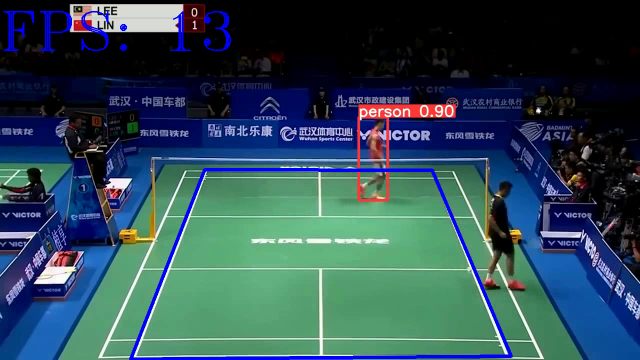

In [10]:
show_video('yolov5/runs/detect/exp3/single_video.mp4')

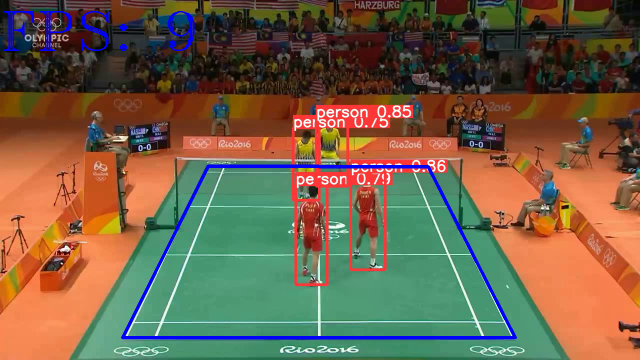

In [74]:
show_video('yolov5/runs/detect/exp4/double_video.mp4')

In [8]:
%pwd
# %cd ../

'C:\\Users\\Lyu\\Desktop\\notebook'

In [77]:
%matplotlib inline


## The method 2 with YOLOV8

Save the result in the current directory ultralytics_rc_output

In [82]:
!python yolov8_double_task3.py --source "double_video.avi" --save-img --view-img
#Press and hold Q to end detection



0: 384x640 3 persons, 124.5ms
Speed: 1.0ms preprocess, 124.5ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 207.0ms
Speed: 2.0ms preprocess, 207.0ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 215.0ms
Speed: 4.0ms preprocess, 215.0ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 182.9ms
Speed: 3.0ms preprocess, 182.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 180.0ms
Speed: 2.0ms preprocess, 180.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 184.5ms
Speed: 2.0ms preprocess, 184.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 76.0ms
Speed: 2.0ms preprocess, 76.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 1.0ms postprocess per imag

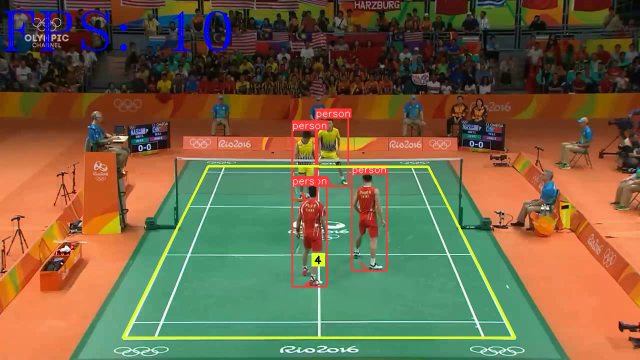

In [17]:
show_video('ultralytics_rc_output/exp/double_video.mp4')

In [18]:
!python yolov8_single_task3.py --source "single_video.avi" --save-img --view-img
#Press and hold Q to end detection


0: 384x640 2 persons, 173.1ms
Speed: 3.0ms preprocess, 173.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 236.4ms
Speed: 3.0ms preprocess, 236.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 237.6ms
Speed: 2.0ms preprocess, 237.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 253.5ms
Speed: 3.0ms preprocess, 253.5ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 181.0ms
Speed: 2.0ms preprocess, 181.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 74.0ms
Speed: 3.0ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 227.1ms
Speed: 4.0ms preprocess, 227.1ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 207.0ms
Speed: 4.0ms preprocess, 207.0ms inference, 4.0ms postprocess per im

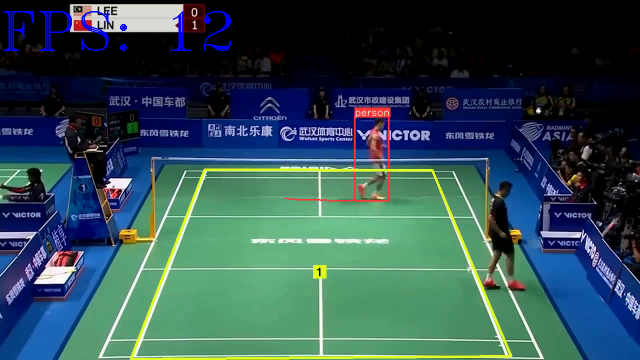

In [19]:
show_video('ultralytics_rc_output/exp5/single_video.mp4')

# TASK4

Image series processing for target tracking, a process that entails dynamic tracking of a target across frames using the model's ability to accurately recognize and track the target. The tracking results are meticulously recorded into video files. To accomplish this task, I used yolov8 to track the characters, where the tracking algorithm invokes a Kalman filter. Each tracked player displays its own movement path and its own tracking ID.

In order to ensure that players within range are always tracked, I made two improvements. The first point, in order to filter spectators outside the stadium, based on the coordinates of the stadium boundaries obtained in the previous task, I set up an area to ensure that the tracking targets players within the stadium boundaries. All players will be marked with a red border, and if they are outside the stadium, they will be specifically marked with a green box. It is important to note that considering the rules, if a player goes out of bounds (foul) it will also be detected as a green box. The second point is that, taking into account that the top half of the players on one side of the court tends to be located on the outside of the court, the program will first mark the identified players and then determine the bottom center coordinates of all the players to make sure that the players will be marked correctly.


In [20]:
!python yolov8_region_counter_double.py --source "double_video.avi" --save-img --view-img
#Press and hold Q to end detection


0: 384x640 3 persons, 213.9ms
Speed: 3.0ms preprocess, 213.9ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 65.5ms
Speed: 2.0ms preprocess, 65.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 54.1ms
Speed: 1.0ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 52.1ms
Speed: 2.0ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 54.1ms
Speed: 1.0ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 71.0ms
Speed: 2.0ms preprocess, 71.0ms inference, 2.0ms postprocess per image at shape

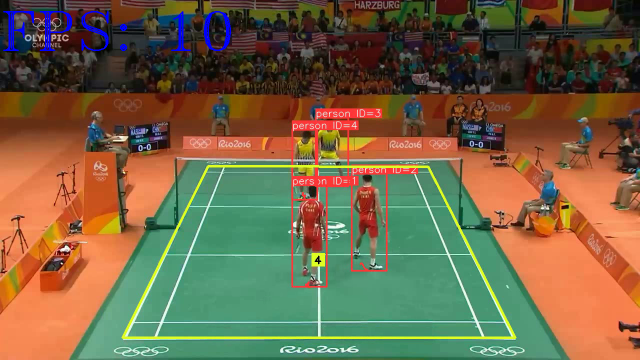

In [21]:
#result of double trakcing
show_video('ultralytics_rc_output/exp2/double_video.mp4')

In [22]:
!python yolov8_region_counter_single.py --source "single_video.avi" --save-img --view-img
#Press and hold Q to end detection


0: 384x640 2 persons, 232.7ms
Speed: 2.0ms preprocess, 232.7ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 55.0ms
Speed: 1.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 46.1ms
Speed: 2.0ms preprocess, 46.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 52.0ms
Speed: 2.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 67.0ms
Speed: 1.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape

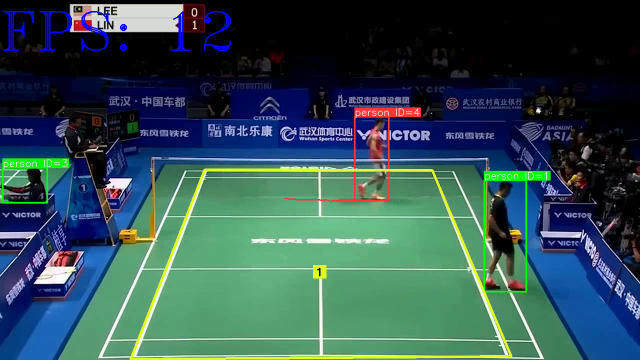

In [23]:
#result of single trakcing
show_video('ultralytics_rc_output/exp3/single_video.mp4')

## I modified part of the code of yolov8_region_counter_double.py myself, you can check the yolov8_region_counter_double.py file in the current directory for details

In [ ]:
import argparse
from collections import defaultdict
from pathlib import Path

import cv2
import numpy as np
from shapely.geometry import Polygon, Point

from ultralytics import YOLO
from ultralytics.utils.files import increment_path
from ultralytics.utils.plotting import Annotator, colors

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

track_history = defaultdict(list)
current_region = None
counting_regions = [
    {
        # "name": "YOLOv8矩形区域",[[1030.5, 675.5], [245.0, 675.0], [416.0, 332.0], [856.0, 333.0]]
        "polygon": Polygon([(416.0, 332.0), (856.0, 333.0), (1030.5, 675.5), (245.0, 675.0)]),  # 多边形顶点
        "counts": 0,
        "dragging": False,
        "region_color": (37, 255, 225),  # BGR值
        "text_color": (0, 0, 0),  # 区域文本颜色
    },
]
next_object_id = 0

def mouse_callback(event, x, y, flags, param):
    """
    处理区域操作的鼠标事件。
    """
    global current_region

    # 鼠标左键按下事件
    if event == cv2.EVENT_LBUTTONDOWN:
        for region in counting_regions:
            if region["polygon"].contains(Point((x, y))):
                current_region = region
                current_region["dragging"] = True
                current_region["offset_x"] = x
                current_region["offset_y"] = y

    # 鼠标移动事件
    elif event == cv2.EVENT_MOUSEMOVE:
        if current_region is not None and current_region["dragging"]:
            dx = x - current_region["offset_x"]
            dy = y - current_region["offset_y"]
            current_region["polygon"] = Polygon(
                [(p[0] + dx, p[1] + dy) for p in current_region["polygon"].exterior.coords]
            )
            current_region["offset_x"] = x
            current_region["offset_y"] = y

    # 鼠标左键释放事件
    elif event == cv2.EVENT_LBUTTONUP:
        if current_region is not None and current_region["dragging"]:
            current_region["dragging"] = False


def run(
    weights="yolov8n.pt",
    source=None,
    device="cpu",
    view_img=False,
    save_img=False,
    exist_ok=False,
    classes=None,
    line_thickness=2,
    track_thickness=2,
    region_thickness=2,
):
    """
    运行YOLOv8指定区域的视频区域计数。

    支持在特定区域内进行实时计数的可移动区域。
    支持多个区域计数。
    区域可以是多边形或矩形形状。

    参数:
        weights (str): 模型权重路径。
        source (str): 视频文件路径。
        device (str): 处理设备 cpu，0，1。
        view_img (bool): 显示结果。
        save_img (bool): 保存结果。
        exist_ok (bool): 允许覆盖现有文件。
        classes (list): 要检测和跟踪的类别。
        line_thickness (int): 边界框厚度。
        track_thickness (int): 跟踪线厚度。
        region_thickness (int): 区域厚度。
    """
    vid_frame_count = 0

    # 检查源路径
    if not Path(source).exists():
        raise FileNotFoundError(f"源路径 '{source}' 不存在。")

    # 设置模型
    model = YOLO(f"{weights}")
    model.to("cuda") if device == "0" else model.to("cpu")

    # 提取类名
    names = model.model.names

    # 视频设置
    videocapture = cv2.VideoCapture(source)
    frame_width, frame_height = int(videocapture.get(3)), int(videocapture.get(4))
    fps, fourcc = int(videocapture.get(5)), cv2.VideoWriter_fourcc(*"mp4v")

    # 输出设置
    save_dir = increment_path(Path("ultralytics_rc_output") / "exp", exist_ok)
    save_dir.mkdir(parents=True, exist_ok=True)
    video_writer = cv2.VideoWriter(str(save_dir / f"{Path(source).stem}.mp4"), fourcc, fps, (frame_width, frame_height))

    # 遍历视频帧
    while videocapture.isOpened():
        success, frame = videocapture.read()
        if not success:
            break
        vid_frame_count += 1

        # 提取结果
        results = model.track(frame, persist=True, classes=classes)

        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            clss = results[0].boxes.cls.cpu().tolist()

            annotator = Annotator(frame, line_width=line_thickness, example=str(names))

            for box, track_id, cls in zip(boxes, track_ids, clss):
                bbox_center = (box[0] + box[2]) / 2, box[3]  # 边界框底部中心

                # 检查底部中心点是否在任何区域内
                in_region = False
                for region in counting_regions:
                    if region["polygon"].contains(Point(bbox_center)):
                        in_region = True
                        region["counts"] += 1
                        annotator.box_label(box, f"{str(names[cls])} ID={track_id}", color=colors(cls, True))
                        track = track_history[track_id]  # 跟踪线绘制
                        track.append((float(bbox_center[0]), float(bbox_center[1])))
                        if len(track) > 30:
                            track.pop(0)
                        points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                        cv2.polylines(frame, [points], isClosed=False, color=colors(cls, True), thickness=track_thickness)
                        break

                # 如果不在任何区域内，则将标记框颜色设置为绿色
                if not in_region:
                    annotator.box_label(box, f"{str(names[cls])} ID={track_id}", color=(0, 255, 0))  # 绿色

        # 绘制区域（多边形/矩形）
        for region in counting_regions:
            region_label = str(region["counts"])
            region_color = region["region_color"]
            region_text_color = region["text_color"]

            polygon_coords = np.array(region["polygon"].exterior.coords, dtype=np.int32)
            centroid_x, centroid_y = int(region["polygon"].centroid.x), int(region["polygon"].centroid.y)

            text_size, _ = cv2.getTextSize(
                region_label, cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=line_thickness
            )
            text_x = centroid_x - text_size[0] // 2
            text_y = centroid_y + text_size[1] // 2
            cv2.rectangle(
                frame,
                (text_x - 5, text_y - text_size[1] - 5),
                (text_x + text_size[0] + 5, text_y + 5),
                region_color,
                -1,
            )
            cv2.putText(
                frame, region_label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, region_text_color, line_thickness
            )
            cv2.polylines(frame, [polygon_coords], isClosed=True, color=region_color, thickness=region_thickness)

        if view_img:
            if vid_frame_count == 1:
                cv2.namedWindow("Ultralytics YOLOv8 Region Counter Movable")
                cv2.setMouseCallback("Ultralytics YOLOv8 Region Counter Movable", mouse_callback)
            cv2.imshow("Ultralytics YOLOv8 Region Counter Movable", frame)

        if save_img:
            video_writer.write(frame)

        for region in counting_regions:  # 为每个区域重新初始化计数
            region["counts"] = 0

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    del vid_frame_count
    video_writer.release()
    videocapture.release()
    cv2.destroyAllWindows()


def parse_opt():
    """解析命令行参数。"""
    parser = argparse.ArgumentParser()
    parser.add_argument("--weights", type=str, default="yolov8n.pt", help="初始权重路径")
    parser.add_argument("--device", default="", help="cuda 设备，例如 0 或 0,1,2,3 或 cpu")
    parser.add_argument("--source", type=str, required=True, help="视频文件路径")
    parser.add_argument("--view-img", action="store_true", help="显示结果")
    parser.add_argument("--save-img", action="store_true", help="保存结果")
    parser.add_argument("--exist-ok", action="store_true", help="现有项目/名称 ok，不增加")
    parser.add_argument("--classes", nargs="+", type=int, default='0', help="按类过滤: --classes 0，或 --classes 0 2 3")
    parser.add_argument("--line-thickness", type=int, default=2, help="边界框厚度")
    parser.add_argument("--track-thickness", type=int, default=2, help="跟踪线厚度")
    parser.add_argument("--region-thickness", type=int, default=4, help="区域厚度")

    return parser.parse_args()


def main(opt):
    """主函数。"""
    run(**vars(opt))


# if __name__ == "__main__":
#     opt = parse_opt()
#     main(opt)
